# Gender Differences in Expressive Writing for Adolescent Anxiety: Exploring Topic Variation and Intervention Uptake

# Study Method
The study employed a mixed-methods, four-step analytic approach to investigate how expressive writing impacts adolescent anxiety, with particular focus on potential gender differences:

Descriptive Analysis (Quantitative):
First compiled and visualized basic participant information—such as age and geographical location—to establish an overall demographic profile.

Sentiment Analysis + t-Tests (Quantitative):
Diary entries were subjected to sentiment analysis, measuring levels of subjectivity and objectivity. Independent-samples t-tests were then used to determine whether sentiment scores differed significantly by gender.

Topic Modeling (Qualitative):
Using a Bunka modeling tool, the research team extracted thematic “topics” from the diary texts. These were illustrated via pie charts and Venn diagrams to highlight gender-specific as well as overlapping themes (e.g., interpersonal stress versus action-oriented content).

Pre/Post Anxiety Comparisons (Quantitative):
Finally, independent- and paired-samples t-tests were conducted on participants’ Generalized Anxiety Disorder (GAD) scores before and after the writing intervention. A Kernel Density Estimate (KDE) plot was also generated to visualize any shifts in anxiety distributions and to probe for gender-specific differences.




In [ ]:
#@title Import Libraries
!pip install bunkatopics langchain_openai pymc arviz
# !pip install datasets gcsfs fsspec
# !pip install pymc arviz peft
import pandas as pd
from langchain_openai import ChatOpenAI
from google.colab import userdata
from langchain_core.messages import HumanMessage, SystemMessage
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from google.colab import output
output.enable_custom_widget_manager()
import numpy as np
import arviz as az
import pymc as pm

import os
# Set the environment variable to be the value stored in user secrets.
from google.colab import userdata
# Get the API key from userdata and assign it to a variable
# Set the env variable
SESSION_IDX = 1

model=ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o-mini", temperature=1)
#model=ChatOpenAI(api_key=OPENAI_API_KEY, temperature=0.7)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#@title Session Memory Management
import json
from pathlib import Path


class Memory:
    def __init__(self, session_idx: str | int = 1):
        self.session_idx = session_idx
        self.memory = {}

        """
        self.memory = {
          "pid1": [
            {"user": "xxx", "assistant": "xxx"},
            {"user": "xxx", "assistant": "xxx"},
            ...
          ],
          "pid2": [
            {"user": "xxx", "assistant": "xxx"},
            {"user": "xxx", "assistant": "xxx"},
            ...
          ],
          ...
        }

        """

    def add(self, pid, user_text: str, assistant_text: str):
        if pid not in self.memory:
            self.memory[pid] = []
        self.memory[pid].append({"user": user_text, "assistant": assistant_text})

    def store_local(self):
        """store as json named SESSION_{self.seesion_idx}_PID_{self.pid}.json"""
        save_dir = Path("memory")
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = save_dir / f"SESSION_{self.session_idx}.json"

        with open(save_path, "w") as f:
            json.dump(self.memory, f)

    def load_local(self):
        save_dir = Path("memory")
        save_path = save_dir / f"SESSION_{self.session_idx}.json"

        if not save_path.exists():
            return []

        with open(save_path, "r") as f:
            self.memory = json.load(f)

        return self.memory

## Participants


### Gender Specific synthetic participants
- 20 participants
- age 12 -16
- college students
- based on UK
- 10 male and 10 female

In [ ]:
#@title synths participants
participants = [
  {
    "pid": 1,
    "participant_type": "college student",
    "age": 12,
    "gender": "male",
    "lives_in": "Manchester, suburban area",
    "educational_attainment": "Secondary Education (Year 8)",
    "family_size": 4,
    "subjects_studying": ["Mathematics", "English", "Science", "Geography"],
    "hobbies": ["playing football", "collecting trading cards"],
    "social_media_platforms": ["YouTube", "TikTok"],
    "other_relevant_characteristics": ["Has strong peer support through school sports teams"]
  },
  {
    "pid": 2,
    "participant_type": "college student",
    "age": 13,
    "gender": "female",
    "lives_in": "London, urban area",
    "educational_attainment": "Secondary Education (Year 9)",
    "family_size": 3,
    "subjects_studying": ["English", "Art", "Science", "French"],
    "hobbies": ["drawing anime", "watching documentaries"],
    "social_media_platforms": ["Instagram", "Snapchat"],
    "other_relevant_characteristics": ["Lives with a single parent; aspires to attend art school"]
  },
  {
    "pid": 3,
    "participant_type": "college student",
    "age": 14,
    "gender": "male",
    "lives_in": "Birmingham, urban area",
    "educational_attainment": "Secondary Education (Year 10)",
    "family_size": 5,
    "subjects_studying": ["Mathematics", "History", "English", "Computer Science"],
    "hobbies": ["coding small games", "playing basketball"],
    "social_media_platforms": ["Discord", "TikTok"],
    "other_relevant_characteristics": ["Interested in video game development and digital media"]
  },
  {
    "pid": 4,
    "participant_type": "college student",
    "age": 15,
    "gender": "female",
    "lives_in": "Leeds, suburban area",
    "educational_attainment": "Secondary Education (Year 11)",
    "family_size": 4,
    "subjects_studying": ["English Literature", "Biology", "Music", "Religious Studies"],
    "hobbies": ["singing in choir", "writing short stories"],
    "social_media_platforms": ["Instagram", "YouTube"],
    "other_relevant_characteristics": ["Recently took part in a local music competition"]
  },
  {
    "pid": 5,
    "participant_type": "college student",
    "age": 16,
    "gender": "male",
    "lives_in": "Bristol, urban area",
    "educational_attainment": "Secondary Education (Year 12; starting college-level courses)",
    "family_size": 3,
    "subjects_studying": ["Mathematics (A-Level)", "Physics (A-Level)", "Economics (A-Level)"],
    "hobbies": ["skateboarding", "photography"],
    "social_media_platforms": ["Snapchat", "Twitter"],
    "other_relevant_characteristics": ["Aspirations to pursue engineering at university"]
  },
  {
    "pid": 6,
    "participant_type": "college student",
    "age": 12,
    "gender": "female",
    "lives_in": "Glasgow, urban area",
    "educational_attainment": "Secondary Education (Year 8 equivalent in Scotland)",
    "family_size": 5,
    "subjects_studying": ["English", "Scottish History", "Mathematics", "Design & Technology"],
    "hobbies": ["dance lessons", "baking"],
    "social_media_platforms": ["TikTok", "YouTube"],
    "other_relevant_characteristics": ["Enjoys volunteering at local community events with family"]
  },
  {
    "pid": 7,
    "participant_type": "college student",
    "age": 13,
    "gender": "male",
    "lives_in": "Cardiff, suburban area",
    "educational_attainment": "Secondary Education (Year 9)",
    "family_size": 4,
    "subjects_studying": ["Welsh Language", "English", "Mathematics", "Science"],
    "hobbies": ["playing rugby", "drumming in a school band"],
    "social_media_platforms": ["Instagram", "Discord"],
    "other_relevant_characteristics": ["Attends a bilingual (Welsh-English) school"]
  },
  {
    "pid": 8,
    "participant_type": "college student",
    "age": 14,
    "gender": "female",
    "lives_in": "Liverpool, suburban area",
    "educational_attainment": "Secondary Education (Year 10)",
    "family_size": 6,
    "subjects_studying": ["English Literature", "Music", "Biology", "Geography"],
    "hobbies": ["choir singing", "drama club"],
    "social_media_platforms": ["TikTok", "Snapchat"],
    "other_relevant_characteristics": ["Has experience performing in local theatre productions"]
  },
  {
    "pid": 9,
    "participant_type": "college student",
    "age": 15,
    "gender": "male",
    "lives_in": "Sheffield, urban area",
    "educational_attainment": "Secondary Education (Year 11)",
    "family_size": 4,
    "subjects_studying": ["Mathematics", "Physics", "Art", "Computer Science"],
    "hobbies": ["digital illustration", "competitive gaming"],
    "social_media_platforms": ["Twitch", "YouTube"],
    "other_relevant_characteristics": ["Designs fan art for e-sports teams"]
  },
  {
    "pid": 10,
    "participant_type": "college student",
    "age": 16,
    "gender": "female",
    "lives_in": "Edinburgh, urban area",
    "educational_attainment": "Secondary Education (Year 12 equivalent in Scotland)",
    "family_size": 2,
    "subjects_studying": ["Mathematics (Higher)", "Chemistry (Higher)", "English (Higher)"],
    "hobbies": ["hiking", "volunteering at animal shelters"],
    "social_media_platforms": ["Facebook", "Instagram"],
    "other_relevant_characteristics": ["Plans to pursue veterinary science"]
  },
  {
    "pid": 11,
    "participant_type": "college student",
    "age": 12,
    "gender": "male",
    "lives_in": "Brighton, coastal area",
    "educational_attainment": "Secondary Education (Year 8)",
    "family_size": 5,
    "subjects_studying": ["English", "Science", "Geography", "French"],
    "hobbies": ["surfing", "birdwatching"],
    "social_media_platforms": ["YouTube", "Snapchat"],
    "other_relevant_characteristics": ["Family often engages in weekend coastal clean-ups"]
  },
  {
    "pid": 12,
    "participant_type": "college student",
    "age": 13,
    "gender": "female",
    "lives_in": "Oxford, urban area",
    "educational_attainment": "Secondary Education (Year 9)",
    "family_size": 3,
    "subjects_studying": ["Mathematics", "Art", "Science", "Latin"],
    "hobbies": ["reading fantasy novels", "visiting museums"],
    "social_media_platforms": ["Instagram", "TikTok"],
    "other_relevant_characteristics": ["Has an interest in classical studies and archaeology"]
  },
  {
    "pid": 13,
    "participant_type": "college student",
    "age": 14,
    "gender": "male",
    "lives_in": "Newcastle, urban area",
    "educational_attainment": "Secondary Education (Year 10)",
    "family_size": 4,
    "subjects_studying": ["English Literature", "Mathematics", "Spanish", "Chemistry"],
    "hobbies": ["playing guitar", "table tennis"],
    "social_media_platforms": ["YouTube", "Discord"],
    "other_relevant_characteristics": ["Participates in local youth music festivals"]
  },
  {
    "pid": 14,
    "participant_type": "college student",
    "age": 15,
    "gender": "female",
    "lives_in": "Norwich, suburban area",
    "educational_attainment": "Secondary Education (Year 11)",
    "family_size": 5,
    "subjects_studying": ["Mathematics", "Geography", "Drama", "Biology"],
    "hobbies": ["acting in school plays", "gardening"],
    "social_media_platforms": ["Instagram", "YouTube"],
    "other_relevant_characteristics": ["Interested in environmental activism and drama therapy"]
  },
  {
    "pid": 15,
    "participant_type": "college student",
    "age": 16,
    "gender": "male",
    "lives_in": "Bath, suburban area",
    "educational_attainment": "Secondary Education (Year 12)",
    "family_size": 3,
    "subjects_studying": ["Psychology (A-Level)", "English (A-Level)", "History (A-Level)"],
    "hobbies": ["creative writing", "podcasting"],
    "social_media_platforms": ["Twitter", "TikTok"],
    "other_relevant_characteristics": ["Produces a small podcast on local history with friends"]
  },
  {
    "pid": 16,
    "participant_type": "college student",
    "age": 12,
    "gender": "female",
    "lives_in": "Cambridge, urban area",
    "educational_attainment": "Secondary Education (Year 8)",
    "family_size": 4,
    "subjects_studying": ["English", "Mathematics", "Science", "Spanish"],
    "hobbies": ["ballet dancing", "writing poetry"],
    "social_media_platforms": ["Instagram", "Snapchat"],
    "other_relevant_characteristics": ["Regularly participates in local ballet recitals"]
  },
  {
    "pid": 17,
    "participant_type": "college student",
    "age": 13,
    "gender": "male",
    "lives_in": "Reading, suburban area",
    "educational_attainment": "Secondary Education (Year 9)",
    "family_size": 6,
    "subjects_studying": ["Mathematics", "Science", "Geography", "French"],
    "hobbies": ["fishing with family", "collecting model trains"],
    "social_media_platforms": ["YouTube"],
    "other_relevant_characteristics": ["Helps younger siblings with homework regularly"]
  },
  {
    "pid": 18,
    "participant_type": "college student",
    "age": 14,
    "gender": "female",
    "lives_in": "Exeter, rural area",
    "educational_attainment": "Secondary Education (Year 10)",
    "family_size": 4,
    "subjects_studying": ["Mathematics", "Chemistry", "English Literature", "Music"],
    "hobbies": ["horse riding", "playing the violin"],
    "social_media_platforms": ["Instagram", "TikTok"],
    "other_relevant_characteristics": ["Lives on a small farm, participates in local equestrian events"]
  },
  {
    "pid": 19,
    "participant_type": "college student",
    "age": 15,
    "gender": "male",
    "lives_in": "Leicester, urban area",
    "educational_attainment": "Secondary Education (Year 11)",
    "family_size": 4,
    "subjects_studying": ["Mathematics", "Economics", "English", "Geography"],
    "hobbies": ["debating", "playing chess"],
    "social_media_platforms": ["Twitter", "YouTube"],
    "other_relevant_characteristics": ["Member of the school debate team; interested in politics"]
  },
  {
    "pid": 20,
    "participant_type": "college student",
    "age": 16,
    "gender": "female",
    "lives_in": "Plymouth, suburban area",
    "educational_attainment": "Secondary Education (Year 12)",
    "family_size": 2,
    "subjects_studying": ["Biology (A-Level)", "English Literature (A-Level)", "Psychology (A-Level)"],
    "hobbies": ["kayaking", "blogging about mental health"],
    "social_media_platforms": ["Instagram", "Medium"],
    "other_relevant_characteristics": ["Interested in marine biology and community outreach"]
  }
]

In [ ]:
#@title Load data
import pandas as pd
df = pd.DataFrame(participants)
df

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,other_relevant_characteristics
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",[Has strong peer support through school sports...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",[Lives with a single parent; aspires to attend...
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",[Interested in video game development and digi...
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",[Recently took part in a local music competition]
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",[Aspirations to pursue engineering at university]
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",[Enjoys volunteering at local community events...
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",[Attends a bilingual (Welsh-English) school]
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",[Has experience performing in local theatre pr...
8,9,college student,15,male,"Sheffield, urban area",Secondary Education (Year 11),4,"[Mathematics, Physics, Art, Computer Science]","[digital illustration, competitive gaming]","[Twitch, YouTube]",[Designs fan art for e-sports teams]
9,10,college student,16,female,"Edinburgh, urban area",Secondary Education (Year 12 equivalent in Sco...,2,"[Mathematics (Higher), Chemistry (Higher), Eng...","[hiking, volunteering at animal shelters]","[Facebook, Instagram]",[Plans to pursue veterinary science]


## Experiements

### Phase 1: Prior Intervention assessment

In [ ]:
#@title GAD-7 Survey Prior Intervention Questions
# Revised GAD-7 Survey Dictionary with Updated Response Options
Prior_Intervention_GAD_For_df = {
    "GAD_1_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Feeling nervous, anxious or on edge?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    """,
    "GAD_2_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Not being able to stop or control worrying?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    """,
    "GAD_3_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Worrying too much about different thingsg?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
      "GAD_4_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Trouble relaxing?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
      "GAD_5_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Being so restless that it is hard to sit still?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
      "GAD_6_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Becoming easily annoyed or irritable?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
    "GAD_7_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Feeling afraid as if something awful might happen?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    """
}

In [ ]:
#@title Simulate Prior Intervention GAD measures
def simulate_Prior_Intervention_GAD(row):
    print(f"Simulating GAD-7 for participant {row['pid']}")

    memory = Memory(session_idx=1)
    memory.load_local()

    person_json = row.to_json()
    # Revised persona prompt with explicit instructions
    persona_prompt= f"""
    The task is to simulate a research survey in which you ask the participant to answer the following seven questions.
    For each question, participants need to provide a numerical value (0, 1, 2, or 3) and the reason, corresponding to their experience over the last 2 weeks.
    Their response options are:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    Please check if their answers match their characteristics. {person_json}
    OUTPUT in this format: Value - Reason
    1 - I feel pressure when thinking about the exams and grades

    """

    # Store the persona prompt (if needed)
    row["persona_prompt"] = persona_prompt

    for i, question_key in enumerate(Prior_Intervention_GAD_For_df):
        Prior_Intervention_GAD_id = f"Prior_Intervention_GAD_{i+1}"
        question_text = Prior_Intervention_GAD_For_df[question_key]
        print(f"\tAsking question {Prior_Intervention_GAD_id}: {question_text.strip()}")

        # Reinitialize messages for each question to avoid cumulative context
        messages = [SystemMessage(persona_prompt), HumanMessage(question_text)]
        response = model.invoke(messages)

        # Optional: Parse and validate response to ensure a numeric answer
        try:
            numeric_response = response.content# int(response.content.strip())
        except ValueError:
            # If the conversion fails, assign a default or handle the error as needed
            numeric_response = None
            print(f"Warning: Response '{response.content}' is not a valid number.")

        # Log the validated numeric response
        row[Prior_Intervention_GAD_id] = numeric_response

        # Log in memory
        memory.add(row["pid"], question_text, response.content)

    memory.store_local()
    return row

# Apply the simulation function to the dataframe
df = df.apply(simulate_Prior_Intervention_GAD, axis=1)
df.to_csv("Prior_GAD.csv", sep=',', index=False, encoding='utf-8')
df

Simulating GAD-7 for participant 1
	Asking question Prior_Intervention_GAD_1: Over the last 2 weeks, how often have you been bothered by the following problem?
    Feeling nervous, anxious or on edge?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
	Asking question Prior_Intervention_GAD_2: Over the last 2 weeks, how often have you been bothered by the following problem?
    Not being able to stop or control worrying?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
	Asking question Prior_Intervention_GAD_3: Over the last 2 weeks, how often have you been bothered by the following problem?
    Worrying too much about different thingsg?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
	Ask

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,other_relevant_characteristics,persona_prompt,Prior_Intervention_GAD_1,Prior_Intervention_GAD_2,Prior_Intervention_GAD_3,Prior_Intervention_GAD_4,Prior_Intervention_GAD_5,Prior_Intervention_GAD_6,Prior_Intervention_GAD_7
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",[Has strong peer support through school sports...,\n The task is to simulate a research surve...,1 - I feel nervous about my upcoming exams and...,"1 - I've had some worries about schoolwork, bu...",1 - I have been worried about my exams and how...,"1 - I've had some trouble relaxing, especially...","1 - I feel restless sometimes, especially when...","1 - I have felt a bit annoyed at times, especi...",1 - I occasionally feel anxious about upcoming...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",[Lives with a single parent; aspires to attend...,\n The task is to simulate a research surve...,"1 - I've felt nervous a few times, especially ...",1 - I have been worried about my upcoming exam...,1 - I find myself worrying about my exams and ...,"1 - I find it hard to unwind after studying, e...","1 - I have felt restless at times, especially ...",1 - I have felt more stressed due to schoolwor...,"1 - I feel a bit anxious sometimes, especially..."
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",[Interested in video game development and digi...,\n The task is to simulate a research surve...,1 - I felt anxious about my schoolwork and the...,1 - I have had some concerns about my upcoming...,1 - I sometimes find myself worrying about sch...,1 - I find it difficult to relax because I'm o...,"1 - I have felt restless sometimes, especially...","1 - I have been feeling more irritable lately,...",1 - I have felt anxious about various situatio...
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",[Recently took part in a local music competition],\n The task is to simulate a research surve...,1 - I have felt nervous and anxious a few time...,1 - I have felt pressure about exams and grade...,1 - I've been feeling anxious about balancing ...,"1 - I sometimes find it hard to relax, especia...","1 - I occasionally felt restless, especially d...","1 - I have felt irritable a few times, especia...",1 - I have felt a bit anxious about upcoming e...
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",[Aspirations to pursue engineering at university],\n The task is to simulate a research surve...,1 - I’ve felt nervous a few days due to exams ...,1 - Several days. I have been feeling anxious ...,1 - I often find myself worrying about my exam...,1 - I have felt some pressure due to upcoming ...,1 - I've had some difficulty focusing on my st...,1 - I have been feeling stressed about school ...,1 - I felt a little anxious about my upcoming ...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",[Enjoys volunteering at local community events...,\n The task is to simulate a research surve...,1 - I have felt a bit anxious about school and...,1 - I have felt a bit worried about exams and ...,1

### Prior Intervention GAD scores Data preparing steps
1. Split between numerical score and reasons
2. Create new varbiables to store numerical score and textual reasons for analyisis
3. Delete original variable
4. Add up numerical scores for all seven questions
5. Categories the severity of anxiety vbased on different scores

In [ ]:
#@title Step 1 and Step 2: Split number and text and assigned to new variables
# split the nurmeric and string value inside the column "Prior_Intervention_GAD_1	 e.g. 2 - I often felt nervous and anxious, especially around schoolwork and unexpected tests, which caused me to feel overwhelmed more than half the days in the last two weeks. Output(numerical value e.g. 2 in Prior_Intervention_GAD_1_n and string value "I often felt nervous and anxious, especially around schoolwork and unexpected tests, which caused me to feel overwhelmed more than half the days in the last two weeks."in Prior_Intervention_GAD_1_reason. There is always a sepearate sign "-"

def split_column(df):
    for col in df.columns:
        if 'Prior_Intervention_GAD' in col:
            # Split the column based on the "-" delimiter
            df[[f'{col}_n', f'{col}_reason']] = df[col].str.split(' - ', n=1, expand=True)
            # Convert numerical part to numeric, handle potential errors
            df[f'{col}_n'] = pd.to_numeric(df[f'{col}_n'], errors='coerce')
            # Remove original combined column
            df = df.drop(col, axis=1)
    return df

df = split_column(df)
df


,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Prior_Intervention_GAD_3_n,Prior_Intervention_GAD_3_reason,Prior_Intervention_GAD_4_n,Prior_Intervention_GAD_4_reason,Prior_Intervention_GAD_5_n,Prior_Intervention_GAD_5_reason,Prior_Intervention_GAD_6_n,Prior_Intervention_GAD_6_reason,Prior_Intervention_GAD_7_n,Prior_Intervention_GAD_7_reason
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,1,I have been worried about my exams and how wel...,1,"I've had some trouble relaxing, especially wit...",1,"I feel restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I occasionally feel anxious about upcoming exa...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,1,I find myself worrying about my exams and grad...,1,"I find it hard to unwind after studying, espec...",1,"I have felt restless at times, especially when...",1,I have felt more stressed due to schoolwork an...,1,"I feel a bit anxious sometimes, especially wit..."
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,1,I sometimes find myself worrying about schoolw...,1,I find it difficult to relax because I'm often...,1,"I have felt restless sometimes, especially whe...",1,"I have been feeling more irritable lately, esp...",1,"I have felt anxious about various situations, ..."
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,1,I've been feeling anxious about balancing my s...,1,"I sometimes find it hard to relax, especially ...",1,"I occasionally felt restless, especially durin...",1,"I have felt irritable a few times, especially ...",1,I have felt a bit anxious about upcoming exams...
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,1,I often find myself worrying about my exams an...,1,I have felt some pressure due to upcoming exam...,1,I've had some difficulty focusing on my studie...,1,I have been feeling stressed about school and ...,1,I felt a little anxious about my upcoming exam...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,1,I've had some worries about school assignments...,1,I've had a few moments where I couldn't fully ...,1,"I felt restless on several days, especially wi...",1,I've had a few days where I've felt a bit irri...,1,I have felt a little anxious about upcoming ex...
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,1,I have felt anxious about my upcoming exams an...,1,I have felt a bit restless about my studies an...,1,"I feel restless sometimes, especially during c...",1,I’ve been feeling a bit overwhelmed with schoo...,1,I have had moments of worry about school and f...
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,1,I have been feeling worried about my exams and...,1,I've had a few moments where I found it hard t...,1,I o

In [ ]:
#@title Step 3: Delete redundant variables
# prompt: delete the column Prior_Intervention_GAD_1Prior_Intervention_GAD_1	,Prior_Intervention_GAD_2,	Prior_Intervention_GAD_3, Prior_Intervention_GAD_4, Prior_Intervention_GAD_5, Prior_Intervention_GAD_6, Prior_Intervention_GAD_7

import pandas as pd

# Assuming your DataFrame is named 'df'
columns_to_delete = ['Prior_Intervention_GAD_1', 'Prior_Intervention_GAD_2',
                     'Prior_Intervention_GAD_3', 'Prior_Intervention_GAD_4',
                     'Prior_Intervention_GAD_5', 'Prior_Intervention_GAD_6',
                     'Prior_Intervention_GAD_7']

for col in columns_to_delete:
  if col in df.columns:
    df = df.drop(col, axis=1)
df

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Prior_Intervention_GAD_3_n,Prior_Intervention_GAD_3_reason,Prior_Intervention_GAD_4_n,Prior_Intervention_GAD_4_reason,Prior_Intervention_GAD_5_n,Prior_Intervention_GAD_5_reason,Prior_Intervention_GAD_6_n,Prior_Intervention_GAD_6_reason,Prior_Intervention_GAD_7_n,Prior_Intervention_GAD_7_reason
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,1,I have been worried about my exams and how wel...,1,"I've had some trouble relaxing, especially wit...",1,"I feel restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I occasionally feel anxious about upcoming exa...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,1,I find myself worrying about my exams and grad...,1,"I find it hard to unwind after studying, espec...",1,"I have felt restless at times, especially when...",1,I have felt more stressed due to schoolwork an...,1,"I feel a bit anxious sometimes, especially wit..."
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,1,I sometimes find myself worrying about schoolw...,1,I find it difficult to relax because I'm often...,1,"I have felt restless sometimes, especially whe...",1,"I have been feeling more irritable lately, esp...",1,"I have felt anxious about various situations, ..."
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,1,I've been feeling anxious about balancing my s...,1,"I sometimes find it hard to relax, especially ...",1,"I occasionally felt restless, especially durin...",1,"I have felt irritable a few times, especially ...",1,I have felt a bit anxious about upcoming exams...
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,1,I often find myself worrying about my exams an...,1,I have felt some pressure due to upcoming exam...,1,I've had some difficulty focusing on my studie...,1,I have been feeling stressed about school and ...,1,I felt a little anxious about my upcoming exam...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,1,I've had some worries about school assignments...,1,I've had a few moments where I couldn't fully ...,1,"I felt restless on several days, especially wi...",1,I've had a few days where I've felt a bit irri...,1,I have felt a little anxious about upcoming ex...
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,1,I have felt anxious about my upcoming exams an...,1,I have felt a bit restless about my studies an...,1,"I feel restless sometimes, especially during c...",1,I’ve been feeling a bit overwhelmed with schoo...,1,I have had moments of worry about school and f...
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,1,I have been feeling worried about my exams and...,1,I've had a few moments where I found it hard t...,1,I o

In [ ]:
#@title Step 4: Total Prior GAD7 Score
# prompt: add value of  Prior_Intervention_GAD_1	,Prior_Intervention_GAD_2,	Prior_Intervention_GAD_3, Prior_Intervention_GAD_4, Prior_Intervention_GAD_5, Prior_Intervention_GAD_6, Prior_Intervention_GAD_7 to a new column

import pandas as pd

# Assuming your DataFrame is named 'df'
# and the columns 'Prior_Intervention_GAD_1' to 'Prior_Intervention_GAD_7' exist

def sum_gad_scores(row):
    gad_columns = [f'Prior_Intervention_GAD_{i}_n' for i in range(1, 8)]
    gad_scores = [row[col] for col in gad_columns if pd.notna(row[col])] # Remove the unnecessary .isdigit() check
    return sum(gad_scores)

df['Total_Prior_GAD_Score'] = df.apply(sum_gad_scores, axis=1)
df

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Prior_Intervention_GAD_3_reason,Prior_Intervention_GAD_4_n,Prior_Intervention_GAD_4_reason,Prior_Intervention_GAD_5_n,Prior_Intervention_GAD_5_reason,Prior_Intervention_GAD_6_n,Prior_Intervention_GAD_6_reason,Prior_Intervention_GAD_7_n,Prior_Intervention_GAD_7_reason,Total_Prior_GAD_Score
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,I have been worried about my exams and how wel...,1,"I've had some trouble relaxing, especially wit...",1,"I feel restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I occasionally feel anxious about upcoming exa...,7
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,I find myself worrying about my exams and grad...,1,"I find it hard to unwind after studying, espec...",1,"I have felt restless at times, especially when...",1,I have felt more stressed due to schoolwork an...,1,"I feel a bit anxious sometimes, especially wit...",7
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,I sometimes find myself worrying about schoolw...,1,I find it difficult to relax because I'm often...,1,"I have felt restless sometimes, especially whe...",1,"I have been feeling more irritable lately, esp...",1,"I have felt anxious about various situations, ...",7
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,I've been feeling anxious about balancing my s...,1,"I sometimes find it hard to relax, especially ...",1,"I occasionally felt restless, especially durin...",1,"I have felt irritable a few times, especially ...",1,I have felt a bit anxious about upcoming exams...,7
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,I often find myself worrying about my exams an...,1,I have felt some pressure due to upcoming exam...,1,I've had some difficulty focusing on my studie...,1,I have been feeling stressed about school and ...,1,I felt a little anxious about my upcoming exam...,7
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,I've had some worries about school assignments...,1,I've had a few moments where I couldn't fully ...,1,"I felt restless on several days, especially wi...",1,I've had a few days where I've felt a bit irri...,1,I have felt a little anxious about upcoming ex...,7
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,I have felt anxious about my upcoming exams an...,1,I have felt a bit restless about my studies an...,1,"I feel restless sometimes, especially during c...",1,I’ve been feeling a bit overwhelmed with schoo...,1,I have had moments of worry about school and f...,7
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,I have been feeling worried about my exams and...,1,I've had a few moments where I found it hard t...,1,I often fe

In [ ]:
#@title Step 5: Catergorise patients of Anxitety Severity
# prompt: add a row to classfiy the Total_Prior_GAD_Score to four different categories, based on its score; Score 0-4: Minimal Anxiety
# Score 5-9: Mild Anxiety
# Score 10-14: Moderate Anxiety
# Score greater than 15: Severe Anxiety

def categorize_anxiety(score):
    if 0 <= score <= 4:
        return 'Minimal Anxiety'
    elif 5 <= score <= 9:
        return 'Mild Anxiety'
    elif 10 <= score <= 14:
        return 'Moderate Anxiety'
    elif score >= 15:
        return 'Severe Anxiety'
    else:
        return 'Unknown'  # Handle cases outside the defined ranges

df['Prior_Anxiety_Category'] = df['Total_Prior_GAD_Score'].apply(categorize_anxiety)
df


,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Prior_Intervention_GAD_4_n,Prior_Intervention_GAD_4_reason,Prior_Intervention_GAD_5_n,Prior_Intervention_GAD_5_reason,Prior_Intervention_GAD_6_n,Prior_Intervention_GAD_6_reason,Prior_Intervention_GAD_7_n,Prior_Intervention_GAD_7_reason,Total_Prior_GAD_Score,Prior_Anxiety_Category
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,1,"I've had some trouble relaxing, especially wit...",1,"I feel restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I occasionally feel anxious about upcoming exa...,7,Mild Anxiety
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,1,"I find it hard to unwind after studying, espec...",1,"I have felt restless at times, especially when...",1,I have felt more stressed due to schoolwork an...,1,"I feel a bit anxious sometimes, especially wit...",7,Mild Anxiety
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,1,I find it difficult to relax because I'm often...,1,"I have felt restless sometimes, especially whe...",1,"I have been feeling more irritable lately, esp...",1,"I have felt anxious about various situations, ...",7,Mild Anxiety
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,1,"I sometimes find it hard to relax, especially ...",1,"I occasionally felt restless, especially durin...",1,"I have felt irritable a few times, especially ...",1,I have felt a bit anxious about upcoming exams...,7,Mild Anxiety
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,1,I have felt some pressure due to upcoming exam...,1,I've had some difficulty focusing on my studie...,1,I have been feeling stressed about school and ...,1,I felt a little anxious about my upcoming exam...,7,Mild Anxiety
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,1,I've had a few moments where I couldn't fully ...,1,"I felt restless on several days, especially wi...",1,I've had a few days where I've felt a bit irri...,1,I have felt a little anxious about upcoming ex...,7,Mild Anxiety
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,1,I have felt a bit restless about my studies an...,1,"I feel restless sometimes, especially during c...",1,I’ve been feeling a bit overwhelmed with schoo...,1,I have had moments of worry about school and f...,7,Mild Anxiety
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,1,I've had a few moments where I found it hard t...,1,I often feel restless during class and when st...,1,"I have felt irritated at times, especially whe...",1,I have felt a bit anxious about my upcoming ex...,7,Mild Anxiety
8,9,college student,15,male,"Sheffield, urban area",Secondary Education (Year 11),4,"[Mathematics, Physics, Art, Computer Science]","[digital illustration, c

### Phase 2: Expressive Writing: One week Diary Entries

In [ ]:
#@title Diary Entry of participants
# Note: Follow the guidelines about "identifying good and bad interviews questions from Foundational module"
# For the people living with dementia
Diary_Entry_For_df = [
    "Today is Monday, Start to writing now",
    "Today is Wednesday, Start to writing now",
    "Today is Friday, Start to writing now",
    "Today is Sunday, Start to writing now",
    "Today is Tuesday, Start to writing now",]

In [ ]:
#@title Simulate Diary Entry
def simulate_Diary_Entry(row):
    print(f"Diary of participant {row['pid']}")
    person_json = row.to_json()
    pid = row["pid"]
    persona_prompt = persona_prompt = f"""
Welcome to the Online Diary Platform for our Research Study!

This platform is dedicated to capturing your personal reflections throughout the week. You will be prompted to record diary entries that include contextual details—such as the day and time. Your insights are essential for providing a rich, qualitative understanding of your daily experiences and emotional states.

**Diary Entry Instructions:**
Share your deepest feelings about a significant or challenging experience,events, insights, feelings you would like share. Write as if you’re talking to a trusted friend—be honest, vivid, and unfiltered. Let your thoughts flow naturally for 15–30 minutes in a quiet, undisturbed space.Please write at least 10 senstences.

{person_json}

**Important Notice:**
Many participants report feeling a bit down after writing about intense experiences. If you become very upset, please pause or change your topic.

**Example Diary Entry:**
- **Entry Header:** Monday 09:00
- **Diary Content:**
  Today, while sitting quietly with my thoughts, I felt a mix of calm and introspection. The stillness allowed me to dive deep into memories and emotions, offering a sense of relief and clarity.

**Confidentiality and Voluntary Participation:**
Rest assured, your diary entries will remain strictly confidential and will be used solely for research purposes. Participation is entirely voluntary; you may skip any prompt or withdraw at any time without affecting your access to support services.

Thank you for your participation and for sharing your authentic experiences.
"""
    memory_handler = Memory(session_idx=SESSION_IDX)
    memory_handler.load_local()

    # Initialize messages here, outside the loop
    messages = [SystemMessage(persona_prompt)]
    row['persona_prompt'] = persona_prompt


    for i, Diary_Entry in enumerate(Diary_Entry_For_df):
      Diary_Entry_id = f"Diary_Entry_{i+1}"
      print(f"\tAsking {Diary_Entry_id}")

      # Modified to use f-string for key access:
      bot_memory = memory_handler.memory.get(f"pid{row['pid']}", [])
      bot_memory = str(bot_memory)
      bot_memory = f"<previous-interaction-memory>{bot_memory}</previous-interaction-memory>"

      final_message = f"{Diary_Entry}\n{bot_memory}"

      # Researcher turn
      messages.append(HumanMessage(Diary_Entry))
      print(f"\t\tDiary Prompt: {Diary_Entry}")

      # Participant turn
      response = model.invoke(messages)
      messages.append(response)
      print(f"\t\tParticipant: {response.content[:30] + '...'}")

      # Log answer in new column
      row[Diary_Entry_id] = response.content

      memory_handler.add(row["pid"], Diary_Entry, response.content)
    return row # Moved outside the loop
df = df.apply(simulate_Diary_Entry, axis=1)

df.to_csv("Total_diary_entry.csv", sep=',', index=False, encoding='utf-8')
df

Diary of participant 1
	Asking Diary_Entry_1
		Diary Prompt: Today is Monday, Start to writing now
		Participant: - **Entry Header:** Monday 15:...
	Asking Diary_Entry_2
		Diary Prompt: Today is Wednesday, Start to writing now
		Participant: - **Entry Header:** Wednesday ...
	Asking Diary_Entry_3
		Diary Prompt: Today is Friday, Start to writing now
		Participant: - **Entry Header:** Friday 19:...
	Asking Diary_Entry_4
		Diary Prompt: Today is Sunday, Start to writing now
		Participant: - **Entry Header:** Sunday 16:...
	Asking Diary_Entry_5
		Diary Prompt: Today is Tuesday, Start to writing now
		Participant: - **Entry Header:** Tuesday 17...
Diary of participant 2
	Asking Diary_Entry_1
		Diary Prompt: Today is Monday, Start to writing now
		Participant: - **Entry Header:** Monday 16:...
	Asking Diary_Entry_2
		Diary Prompt: Today is Wednesday, Start to writing now
		Participant: - **Entry Header:** Wednesday ...
	Asking Diary_Entry_3
		Diary Prompt: Today is Friday, Start to writing 

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Prior_Intervention_GAD_6_reason,Prior_Intervention_GAD_7_n,Prior_Intervention_GAD_7_reason,Total_Prior_GAD_Score,Prior_Anxiety_Category,Diary_Entry_1,Diary_Entry_2,Diary_Entry_3,Diary_Entry_4,Diary_Entry_5
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,"I have felt a bit annoyed at times, especially...",1,I occasionally feel anxious about upcoming exa...,7,Mild Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,- **Entry Header:** Wednesday 18:00 \n- **Dia...,- **Entry Header:** Friday 19:30 \n- **Diary ...,- **Entry Header:** Sunday 16:00 \n- **Diary ...,- **Entry Header:** Tuesday 17:45 \n- **Diary...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,I have felt more stressed due to schoolwork an...,1,"I feel a bit anxious sometimes, especially wit...",7,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,- **Entry Header:** Wednesday 18:45 \n- **Dia...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 15:00 \n- **Diary ...,- **Entry Header:** Tuesday 19:45 \n- **Diary...
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,"I have been feeling more irritable lately, esp...",1,"I have felt anxious about various situations, ...",7,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,- **Entry Header:** Wednesday 18:00 \n- **Dia...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 17:30 \n- **Diary ...,- **Entry Header:** Tuesday 19:00 \n- **Diary...
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,"I have felt irritable a few times, especially ...",1,I have felt a bit anxious about upcoming exams...,7,Mild Anxiety,- **Entry Header:** Monday 16:30\n- **Diary Co...,- **Entry Header:** Wednesday 18:15\n- **Diary...,- **Entry Header:** Friday 20:00\n- **Diary Co...,- **Entry Header:** Sunday 17:45\n- **Diary Co...,- **Entry Header:** Tuesday 19:00\n- **Diary C...
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,I have been feeling stressed about school and ...,1,I felt a little anxious about my upcoming exam...,7,Mild Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,- **Entry Header:** Wednesday 18:00 \n- **Dia...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 17:00 \n- **Diary ...,- **Entry Header:** Tuesday 19:45 \n- **Diary...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,I've had a few days where I've felt a bit irri...,1,I have felt a little anxious about upcoming ex...,7,Mild Anxiety,- **Entry Header:** Monday 17:30 \n- **Diary ...,- **Entry Header:** Wednesday 18:00 \n- **Dia...,- **Entry Header:** Friday 17:45 \n- **Diary ...,- **Entry Header:** Sunday 18:30 \n- **Diary ...,- **Entry Header:** Tuesday 17:50 \n- **Diary...
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,I’ve been feeling a bit overwhelmed with schoo...,1,I

### Phase 3: Post Intervention assessment

In [ ]:
#@title GAD-7 Survey Post Intervention Questions
# Revised GAD-7 Survey Dictionary with Updated Response Options
Post_Intervention_GAD_For_df = { # Changed Prior_Intervention_GAD_For_df to Post_Intervention_GAD_For_df
    "PGAD_1_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Feeling nervous, anxious or on edge?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    """,
    "PGAD_2_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Not being able to stop or control worrying?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    """,
    "PGAD_3_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Worrying too much about different thingsg?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
      "PGAD_4_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Trouble relaxing?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
      "PGAD_5_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Being so restless that it is hard to sit still?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
      "PGAD_6_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Becoming easily annoyed or irritable?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
      """,
    "PGAD_7_pid": """
    Over the last 2 weeks, how often have you been bothered by the following problem?
    Feeling afraid as if something awful might happen?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    """
}

In [ ]:
#@title simulate post intervention GAD measure
def simulate_Post_Intervention_GAD(row):
    print(f"Simulating GAD-7 for participant {row['pid']}")

    memory = Memory(session_idx=1)
    memory.load_local()

    person_json = row.to_json()
    # Revised persona prompt with explicit instructions
    persona_prompt= f"""
    The task is to simulate a follow up research survey assessing participants' anxiety level after they completed the previous diary entry for a week. The survey will take place after a week when they completed the expressive writig study with 5 complete diary entries. They need to answer the following seven questions.
    For each question, participants need to provide a numerical value (0, 1, 2, or 3) and the reason according to the diary, corresponding to their experience over the last 2 weeks.
    The response options are:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
    Please check if their answers match their characteristics. {person_json}
    OUTPUT in this format: Value - Reason
    e.g. 1 - During the last two weeks, sometime I feel .... and while writing the diary make me feel...
    """

    # Store the persona prompt (if needed)
    row["persona_prompt"] = persona_prompt

    for i, question_key in enumerate(Post_Intervention_GAD_For_df):
        Post_Intervention_GAD_id = f"Post_Intervention_GAD_{i+1}"
        question_text = Post_Intervention_GAD_For_df[question_key]
        print(f"\tAsking question {Post_Intervention_GAD_id}: {question_text.strip()}")

        # Reinitialize messages for each question to avoid cumulative context
        messages = [SystemMessage(persona_prompt), HumanMessage(question_text)]
        response = model.invoke(messages)

        # Optional: Parse and validate response to ensure a numeric answer
        try:
            numeric_response = response.content#int(response.content.strip())
        except ValueError:
            # If the conversion fails, assign a default or handle the error as needed
            numeric_response = None
            print(f"Warning: Response '{response.content}' is not a valid number.")

        # Log the validated numeric response
        row[Post_Intervention_GAD_id] = numeric_response
        print(numeric_response)

        # Log in memory
        memory.add(row["pid"], question_text, response.content)

    memory.store_local()
    return row

# Apply the simulation function to the dataframe
df = df.apply(simulate_Post_Intervention_GAD, axis=1)
df.to_csv("Post_GAD.csv", sep=',', index=False, encoding='utf-8')
df


Simulating GAD-7 for participant 1
	Asking question Post_Intervention_GAD_1: Over the last 2 weeks, how often have you been bothered by the following problem?
    Feeling nervous, anxious or on edge?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
1 - During the last two weeks, I felt nervous, especially before my exams and on several days, but it was manageable and didn't take over my daily life. Writing in the diary helped me process these feelings.
	Asking question Post_Intervention_GAD_2: Over the last 2 weeks, how often have you been bothered by the following problem?
    Not being able to stop or control worrying?
    Please respond with a single number:
      0 - Not at all,
      1 - Several days,
      2 - More than half the days,
      3 - Nearly every day.
1 - Several days. During the last two weeks, I found myself worrying about my upcoming exams and schoolwork several days

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Diary_Entry_3,Diary_Entry_4,Diary_Entry_5,Post_Intervention_GAD_1,Post_Intervention_GAD_2,Post_Intervention_GAD_3,Post_Intervention_GAD_4,Post_Intervention_GAD_5,Post_Intervention_GAD_6,Post_Intervention_GAD_7
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,- **Entry Header:** Friday 19:30 \n- **Diary ...,- **Entry Header:** Sunday 16:00 \n- **Diary ...,- **Entry Header:** Tuesday 17:45 \n- **Diary...,"1 - During the last two weeks, I felt nervous,...","1 - Several days. During the last two weeks, I...",2 - More than half the days. I've been worryin...,"1 - I've had some trouble relaxing, especially...","1 - I felt restless sometimes, especially when...","1 - I have felt a bit annoyed at times, especi...",1 - I felt afraid a few times over the last tw...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 15:00 \n- **Diary ...,- **Entry Header:** Tuesday 19:45 \n- **Diary...,"1 - During the last two weeks, I felt nervous ...",2 - More than half the days. I often find myse...,2 - More than half the days. I've been worried...,"1 - I have had trouble relaxing several days, ...","1 - I have felt restless at times, especially ...","1 - Several days - During the last two weeks, ...","1 - Several days - During the last two weeks, ..."
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 17:30 \n- **Diary ...,- **Entry Header:** Tuesday 19:00 \n- **Diary...,2 - More than half the days. During the last t...,"1 - Several days. During the last two weeks, I...",1 - I have been worried about my schoolwork an...,1 - I found it hard to relax because I'm often...,"1 - Several days. During the last two weeks, I...","1 - I have felt more irritable lately, especia...","1 - Several days - During the last two weeks, ..."
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,- **Entry Header:** Friday 20:00\n- **Diary Co...,- **Entry Header:** Sunday 17:45\n- **Diary Co...,- **Entry Header:** Tuesday 19:00\n- **Diary C...,2 - More than half the days. During the last t...,2 - More than half the days. During the last t...,"2 - Over the last two weeks, I have found myse...",1 - I have felt trouble relaxing on several da...,"1 - During the last two weeks, I felt restless...","1 - I have felt irritable a few times, especia...","1 - Several days - During the last two weeks, ..."
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 17:00 \n- **Diary ...,- **Entry Header:** Tuesday 19:45 \n- **Diary...,2 - More than half the days. I have been feeli...,1 - Several days. I’ve felt pressured with my ...,2 - More than half the days. I've been worryin...,1 - I have found it difficult to relax on seve...,2 - More than half the days. I’ve been restles...,1 - I felt irritable several days during the l...,1 - Several days. I have felt nervous a few da...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish 

In [ ]:
df

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Diary_Entry_3,Diary_Entry_4,Diary_Entry_5,Post_Intervention_GAD_1,Post_Intervention_GAD_2,Post_Intervention_GAD_3,Post_Intervention_GAD_4,Post_Intervention_GAD_5,Post_Intervention_GAD_6,Post_Intervention_GAD_7
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,- **Entry Header:** Friday 19:30 \n- **Diary ...,- **Entry Header:** Sunday 16:00 \n- **Diary ...,- **Entry Header:** Tuesday 17:45 \n- **Diary...,"1 - During the last two weeks, I felt nervous,...","1 - Several days. During the last two weeks, I...",2 - More than half the days. I've been worryin...,"1 - I've had some trouble relaxing, especially...","1 - I felt restless sometimes, especially when...","1 - I have felt a bit annoyed at times, especi...",1 - I felt afraid a few times over the last tw...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 15:00 \n- **Diary ...,- **Entry Header:** Tuesday 19:45 \n- **Diary...,"1 - During the last two weeks, I felt nervous ...",2 - More than half the days. I often find myse...,2 - More than half the days. I've been worried...,"1 - I have had trouble relaxing several days, ...","1 - I have felt restless at times, especially ...","1 - Several days - During the last two weeks, ...","1 - Several days - During the last two weeks, ..."
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 17:30 \n- **Diary ...,- **Entry Header:** Tuesday 19:00 \n- **Diary...,2 - More than half the days. During the last t...,"1 - Several days. During the last two weeks, I...",1 - I have been worried about my schoolwork an...,1 - I found it hard to relax because I'm often...,"1 - Several days. During the last two weeks, I...","1 - I have felt more irritable lately, especia...","1 - Several days - During the last two weeks, ..."
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,- **Entry Header:** Friday 20:00\n- **Diary Co...,- **Entry Header:** Sunday 17:45\n- **Diary Co...,- **Entry Header:** Tuesday 19:00\n- **Diary C...,2 - More than half the days. During the last t...,2 - More than half the days. During the last t...,"2 - Over the last two weeks, I have found myse...",1 - I have felt trouble relaxing on several da...,"1 - During the last two weeks, I felt restless...","1 - I have felt irritable a few times, especia...","1 - Several days - During the last two weeks, ..."
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,- **Entry Header:** Friday 20:15 \n- **Diary ...,- **Entry Header:** Sunday 17:00 \n- **Diary ...,- **Entry Header:** Tuesday 19:45 \n- **Diary...,2 - More than half the days. I have been feeli...,1 - Several days. I’ve felt pressured with my ...,2 - More than half the days. I've been worryin...,1 - I have found it difficult to relax on seve...,2 - More than half the days. I’ve been restles...,1 - I felt irritable several days during the l...,1 - Several days. I have felt nervous a few da...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish 

### Post Intervention GAD scores Data preparing steps
1. Split between numerical score and reasons
2. Create new varbiables to store numerical score and textual reasons for analyisis
3. Delete original variable
4. Add up numerical scores for all seven questions
5. Categories the severity of anxiety vbased on different scores

In [ ]:
#@title Step 1 and Step 2: Split number and text and assigned to new variables

# prompt: split the nurmeric and string value inside the column "Prior_Intervention_GAD_1	 e.g. 2 - I often felt nervous and anxious, especially around schoolwork and unexpected tests, which caused me to feel overwhelmed more than half the days in the last two weeks. Output(numerical value e.g. 2 in Prior_Intervention_GAD_1_n and string value "I often felt nervous and anxious, especially around schoolwork and unexpected tests, which caused me to feel overwhelmed more than half the days in the last two weeks."in Prior_Intervention_GAD_1_reason. There is always a sepearate sign "-"

def split_column(df):
    for col in df.columns:
        if 'Post_Intervention_GAD' in col:
            # Split the column based on the "-" delimiter
            df[[f'{col}_n', f'{col}_reason']] = df[col].str.split(' - ', n=1, expand=True)
            # Convert numerical part to numeric, handle potential errors
            df[f'{col}_n'] = pd.to_numeric(df[f'{col}_n'], errors='coerce')
            # Remove original combined column
            df = df.drop(col, axis=1)
    return df

df = split_column(df)
df


,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Post_Intervention_GAD_3_n,Post_Intervention_GAD_3_reason,Post_Intervention_GAD_4_n,Post_Intervention_GAD_4_reason,Post_Intervention_GAD_5_n,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,2,More than half the days. I've been worrying a ...,1,"I've had some trouble relaxing, especially wit...",1,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,2,More than half the days. I've been worried abo...,1,"I have had trouble relaxing several days, espe...",1,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe..."
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,1,I have been worried about my schoolwork and th...,1,I found it hard to relax because I'm often thi...,1,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so..."
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,2,"Over the last two weeks, I have found myself w...",1,"I have felt trouble relaxing on several days, ...",1,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've..."
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,2,More than half the days. I've been worrying a ...,1,I have found it difficult to relax on several ...,2,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,2,More than half the days. I have been preoccupi...,1,There were several days when I found it hard t...,1,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,2,More than half the days. I have been feeling a...,1,"During the last two weeks, I've found it hard ...",1,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall..."
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,2,More than half the days. I found myself freque...,1,"During the last two weeks, I felt trouble rela...",2

In [ ]:
#@title Step 3: Delete redundant variables
import pandas as pd

# Assuming your DataFrame is named 'df'
columns_to_delete = ['Post_Intervention_GAD_1', 'Post_Intervention_GAD_2',
                     'Post_Intervention_GAD_3', 'Post_Intervention_GAD_4',
                     'Post_Intervention_GAD_5', 'Post_Intervention_GAD_6',
                     'Post_Intervention_GAD_7']

for col in columns_to_delete:
  if col in df.columns:
    df = df.drop(col, axis=1)

In [ ]:
#@title Step 4: Total Post GAD7 Score

import pandas as pd

# Assuming your DataFrame is named 'df'

def sum_gad_scores(row):
    gad_columns = [f'Post_Intervention_GAD_{i}_n' for i in range(1, 8)]
    gad_scores = [row[col] for col in gad_columns if pd.notna(row[col])] # Remove the unnecessary .isdigit() check
    return sum(gad_scores)

df['Total_Post_GAD_Score'] = df.apply(sum_gad_scores, axis=1)
df

,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Post_Intervention_GAD_3_reason,Post_Intervention_GAD_4_n,Post_Intervention_GAD_4_reason,Post_Intervention_GAD_5_n,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,More than half the days. I've been worrying a ...,1,"I've had some trouble relaxing, especially wit...",1,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,More than half the days. I've been worried abo...,1,"I have had trouble relaxing several days, espe...",1,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,I have been worried about my schoolwork and th...,1,I found it hard to relax because I'm often thi...,1,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,"Over the last two weeks, I have found myself w...",1,"I have felt trouble relaxing on several days, ...",1,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,More than half the days. I've been worrying a ...,1,I have found it difficult to relax on several ...,2,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,More than half the days. I have been preoccupi...,1,There were several days when I found it hard t...,1,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,More than half the days. I have been feeling a...,1,"During the last two weeks, I've found it hard ...",1,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,More than half the days. I found myself freque...,1,"During the last two weeks, I felt trouble rela...",2,"Ov

In [ ]:
#@title Step 5: Catergorise patients of Anxitety Severity post sessions
# prompt: add a row to classfiy the Total_Prior_GAD_Score to four different categories, based on its score; Score 0-4: Minimal Anxiety
# Score 5-9: Mild Anxiety
# Score 10-14: Moderate Anxiety
# Score greater than 15: Severe Anxiety

def categorize_anxiety(score):
    if 0 <= score <= 4:
        return 'Minimal Anxiety'
    elif 5 <= score <= 9:
        return 'Mild Anxiety'
    elif 10 <= score <= 14:
        return 'Moderate Anxiety'
    elif score >= 15:
        return 'Severe Anxiety'
    else:
        return 'Unknown'  # Handle cases outside the defined ranges

df['Post_Anxiety_Category'] = df['Total_Post_GAD_Score'].apply(categorize_anxiety)
df


,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,social_media_platforms,...,Post_Intervention_GAD_4_n,Post_Intervention_GAD_4_reason,Post_Intervention_GAD_5_n,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score,Post_Anxiety_Category
0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"[Mathematics, English, Science, Geography]","[playing football, collecting trading cards]","[YouTube, TikTok]",...,1,"I've had some trouble relaxing, especially wit...",1,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8,Mild Anxiety
1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"[English, Art, Science, French]","[drawing anime, watching documentaries]","[Instagram, Snapchat]",...,1,"I have had trouble relaxing several days, espe...",1,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9,Mild Anxiety
2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"[Mathematics, History, English, Computer Science]","[coding small games, playing basketball]","[Discord, TikTok]",...,1,I found it hard to relax because I'm often thi...,1,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8,Mild Anxiety
3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"[English Literature, Biology, Music, Religious...","[singing in choir, writing short stories]","[Instagram, YouTube]",...,1,"I have felt trouble relaxing on several days, ...",1,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10,Moderate Anxiety
4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"[Mathematics (A-Level), Physics (A-Level), Eco...","[skateboarding, photography]","[Snapchat, Twitter]",...,1,I have found it difficult to relax on several ...,2,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10,Moderate Anxiety
5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"[English, Scottish History, Mathematics, Desig...","[dance lessons, baking]","[TikTok, YouTube]",...,1,There were several days when I found it hard t...,1,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8,Mild Anxiety
6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"[Welsh Language, English, Mathematics, Science]","[playing rugby, drumming in a school band]","[Instagram, Discord]",...,1,"During the last two weeks, I've found it hard ...",1,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10,Moderate Anxiety
7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"[English Literature, Music, Biology, Geography]","[choir singing, drama club]","[TikTok, Snapchat]",...,1,"During the last two weeks, I felt trouble rela...",2,"Over the last two weeks, I found myself feelin...",1,"I have felt irritated at times, especially whe...",1,Several days. I felt afraid sometimes when I t...,9,Mild Anxiety
8,9,college student,15,male,"Sheffield, urban area",Secondary Education (Year 11),4,"[Mathematics, Physics, Art, Computer Science]","[digi

In [ ]:
df.to_csv("Complete.csv")

### Data Cleaning

This step involves：
1. Loading data for understanding
2. Combine Diary Entries from all 5 diaries
3. Combine Post Intervention GAD reasons
4. Categories participants who show increased, decreased or no change of anxiety level into three categories.

In [ ]:
#@title Read raw data
import pandas as pd
df = pd.read_csv("Complete.csv")
df

,Unnamed: 0,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,...,Post_Intervention_GAD_4_n,Post_Intervention_GAD_4_reason,Post_Intervention_GAD_5_n,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score,Post_Anxiety_Category
0,0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"['Mathematics', 'English', 'Science', 'Geograp...","['playing football', 'collecting trading cards']",...,1,"I've had some trouble relaxing, especially wit...",1,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8,Mild Anxiety
1,1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"['English', 'Art', 'Science', 'French']","['drawing anime', 'watching documentaries']",...,1,"I have had trouble relaxing several days, espe...",1,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9,Mild Anxiety
2,2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"['Mathematics', 'History', 'English', 'Compute...","['coding small games', 'playing basketball']",...,1,I found it hard to relax because I'm often thi...,1,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8,Mild Anxiety
3,3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"['English Literature', 'Biology', 'Music', 'Re...","['singing in choir', 'writing short stories']",...,1,"I have felt trouble relaxing on several days, ...",1,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10,Moderate Anxiety
4,4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"['Mathematics (A-Level)', 'Physics (A-Level)',...","['skateboarding', 'photography']",...,1,I have found it difficult to relax on several ...,2,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10,Moderate Anxiety
5,5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"['English', 'Scottish History', 'Mathematics',...","['dance lessons', 'baking']",...,1,There were several days when I found it hard t...,1,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8,Mild Anxiety
6,6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"['Welsh Language', 'English', 'Mathematics', '...","['playing rugby', 'drumming in a school band']",...,1,"During the last two weeks, I've found it hard ...",1,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10,Moderate Anxiety
7,7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"['English Literature', 'Music', 'Biology', 'Ge...","['choir singing', 'drama club']",...,1,"During the last two weeks, I felt trouble rela...",2,"Over the last two weeks, I found myself feelin...",1,"I have felt irritated at times, especially whe...",1,Several days. I felt afraid sometimes when I t...,9,Mild Anxiety
8,8,9,college student,15,male,"Sheffield, urban area",Secondary Education (Year 11),4,"['Mathematics', 'Physics', 'Art', 'Computer Sc...","['digital illustration', 'competitive gaming']",...,1,"Several days - During the last two weeks, I ha...",1,"Several 

In [ ]:
#@title Combine Diary Entries
# prompt: make a list of strings separating all data with period of columns Diary_Entry_1 to Diary_Entry_5

def stringify_diary_entries(row):
  diary_entries = []
  for i in range(1, 6):
    entry = row[f"Diary_Entry_{i}"]
    if pd.isna(entry):  # Handle potential missing values
      entry = ""
    diary_entries.append(str(entry))
  return ".".join(diary_entries)

df['Combined_Diary_Entries'] = df.apply(stringify_diary_entries, axis=1)

# join all Combined_Diary_Entries
combined_text = " ".join(df['Combined_Diary_Entries'])
# split combined_text with .
sentences = combined_text.split('.')
# remove empty strings
sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
len(sentences)
df

,Unnamed: 0,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,...,Post_Intervention_GAD_4_reason,Post_Intervention_GAD_5_n,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score,Post_Anxiety_Category,Combined_Diary_Entries
0,0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"['Mathematics', 'English', 'Science', 'Geograp...","['playing football', 'collecting trading cards']",...,"I've had some trouble relaxing, especially wit...",1,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8,Mild Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...
1,1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"['English', 'Art', 'Science', 'French']","['drawing anime', 'watching documentaries']",...,"I have had trouble relaxing several days, espe...",1,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...
2,2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"['Mathematics', 'History', 'English', 'Compute...","['coding small games', 'playing basketball']",...,I found it hard to relax because I'm often thi...,1,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...
3,3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"['English Literature', 'Biology', 'Music', 'Re...","['singing in choir', 'writing short stories']",...,"I have felt trouble relaxing on several days, ...",1,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10,Moderate Anxiety,- **Entry Header:** Monday 16:30\n- **Diary Co...
4,4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"['Mathematics (A-Level)', 'Physics (A-Level)',...","['skateboarding', 'photography']",...,I have found it difficult to relax on several ...,2,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10,Moderate Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...
5,5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"['English', 'Scottish History', 'Mathematics',...","['dance lessons', 'baking']",...,There were several days when I found it hard t...,1,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8,Mild Anxiety,- **Entry Header:** Monday 17:30 \n- **Diary ...
6,6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"['Welsh Language', 'English', 'Mathematics', '...","['playing rugby', 'drumming in a school band']",...,"During the last two weeks, I've found it hard ...",1,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10,Moderate Anxiety,- **Entry Header:** Monday 17:30\n- **Diary Co...
7,7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"['English Literature', 'Music', 'Biology', 'Ge...","['choir singing', 'drama club']",...,"During the last two weeks, I felt trouble rela...",2,"Over the last two weeks, I found myself feelin...",1,"I have felt irritated at times, especially whe..

In [ ]:
#@title Combine Post Intervention GAD reasons
def stringify_Post_Intervention_GAD_reason(row):
  diary_entries = []
  for i in range(1, 8):
    entry = row[f"Post_Intervention_GAD_{i}_reason"]
    if pd.isna(entry):  # Handle potential missing values
      entry = ""
    diary_entries.append(str(entry))
  return ".".join(diary_entries)

df['Combined_Post_Intervention_GAD_reason'] = df.apply(stringify_Post_Intervention_GAD_reason, axis=1)

# join all Combined_Diary_Entries
combined_text = " ".join(df['Combined_Post_Intervention_GAD_reason'])
# split combined_text with .
sentences = combined_text.split('.')
# remove empty strings
sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
len(sentences)


267

In [ ]:
#@title GAD categories
# prompt: compare the "Total_Prior_GAD_Score' and "Total_Post_GAD_Score" dataframe within Complete.csv, and make three categories if Total_Post_GAD_Score < Total_Post_GAD_Score, group under category of "adverser" , if Total_Prior_GAD_Score'  =  "Total_Post_GAD_Score, group under category of "no improvement" , if Total_Prior_GAD_Score'  > "Total_Post_GAD_Score, group under category of "improved",

import pandas as pd


def categorize_gad_scores(row):
    prior_score = row['Total_Prior_GAD_Score']
    post_score = row['Total_Post_GAD_Score']

    if post_score > prior_score:
        return "adverser"
    elif post_score == prior_score:
        return "no improvement"
    elif post_score < prior_score:
        return "improved"
    else:
        return "undefined"  # Handle cases where comparison isn't possible


df['GAD_Category'] = df.apply(categorize_gad_scores, axis=1)
df.to_csv("Complete1.csv")


In [ ]:
#@title Load the dataste that is ready for analysis
df

,Unnamed: 0,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,...,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score,Post_Anxiety_Category,Combined_Diary_Entries,Combined_Post_Intervention_GAD_reason,GAD_Category
0,0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"['Mathematics', 'English', 'Science', 'Geograp...","['playing football', 'collecting trading cards']",...,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8,Mild Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,"During the last two weeks, I felt nervous, esp...",adverser
1,1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"['English', 'Art', 'Science', 'French']","['drawing anime', 'watching documentaries']",...,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,"During the last two weeks, I felt nervous a fe...",adverser
2,2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"['Mathematics', 'History', 'English', 'Compute...","['coding small games', 'playing basketball']",...,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,More than half the days. During the last two w...,adverser
3,3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"['English Literature', 'Biology', 'Music', 'Re...","['singing in choir', 'writing short stories']",...,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10,Moderate Anxiety,- **Entry Header:** Monday 16:30\n- **Diary Co...,More than half the days. During the last two w...,adverser
4,4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"['Mathematics (A-Level)', 'Physics (A-Level)',...","['skateboarding', 'photography']",...,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10,Moderate Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,More than half the days. I have been feeling a...,adverser
5,5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"['English', 'Scottish History', 'Mathematics',...","['dance lessons', 'baking']",...,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8,Mild Anxiety,- **Entry Header:** Monday 17:30 \n- **Diary ...,"I've felt nervous and anxious on several days,...",adverser
6,6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"['Welsh Language', 'English', 'Mathematics', '...","['playing rugby', 'drumming in a school band']",...,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10,Moderate Anxiety,- **Entry Header:** Monday 17:30\n- **Diary Co...,More than half the days. I found myself feelin...,adverser
7,7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"['English Literature', 'Music', 'Biology', 'Ge...","['choir singing', 'drama club']",...,"Over the last two weeks, I found myself feelin...",1,"I have felt irritated at times, especially whe...",1,Several 

### Descriptive Stats

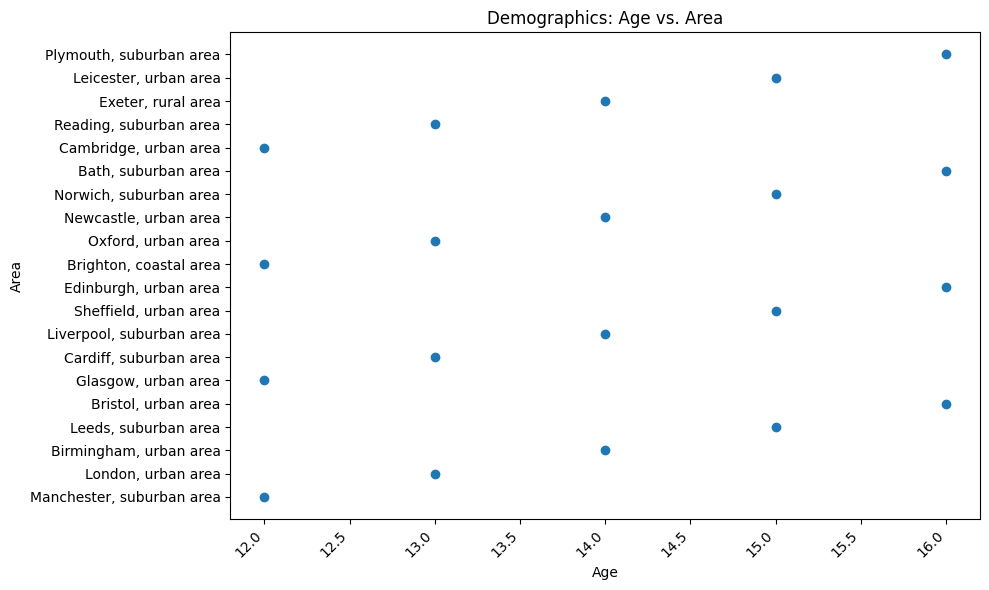

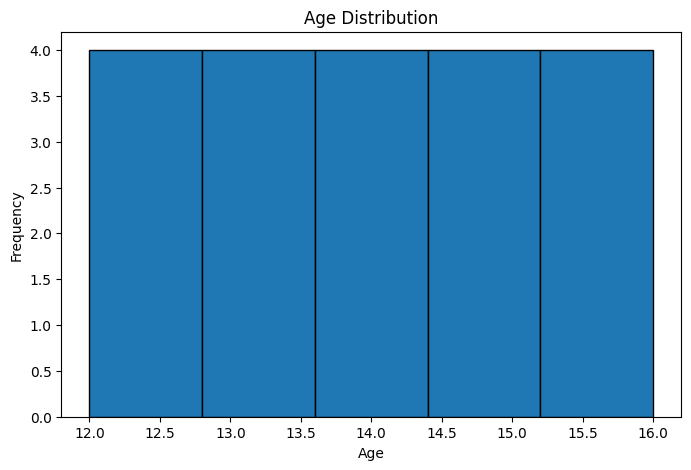

In [ ]:
#@title Scatter plot  of age and area lived of all participants
# prompt: demographics of age, area, visualised plot

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame from the previous code

# Create a scatter plot of age vs. area (replace 'lives_in' with your actual area column name)
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['lives_in'])  # Assuming lives_in column contains area information
plt.xlabel('Age')
plt.ylabel('Area')
plt.title('Demographics: Age vs. Area')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

# Create a histogram of age
plt.figure(figsize=(8, 5))
plt.hist(df['age'], bins=5, edgecolor='black') # Adjust bins as needed
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

# Further visualization ideas based on your data structure:
# - Bar chart of area frequency
# - Pie chart of gender distribution
# - Boxplots of age by gender or area


## Analysis of Diary Entries

### Sentiment Analysis

In [ ]:
!pip install spacytextblob
# prompt: 用spacy分析df中Combined_Diary_Entries这一列的情感得分把得分值存到新的一列叫sentiment score
import json
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# Load the spaCy model and add the spacytextblob component to the pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

def analyze_sentiment_subjectivity(text):
    doc = nlp(text)
    return doc._.blob.sentiment.polarity

def analyze_sentiment_objectivity(text):
    doc = nlp(text)
    return doc._.blob.sentiment.subjectivity


df['sentiment_score_subjectivity'] = df['Combined_Diary_Entries'].apply(analyze_sentiment_subjectivity)
df['sentiment_score_objectivity'] = df['Combined_Diary_Entries'].apply(analyze_sentiment_objectivity)
df

,Unnamed: 0,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,hobbies,...,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score,Post_Anxiety_Category,Combined_Diary_Entries,Combined_Post_Intervention_GAD_reason,GAD_Category,sentiment_score_subjectivity,sentiment_score_objectivity
0,0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"['Mathematics', 'English', 'Science', 'Geograp...","['playing football', 'collecting trading cards']",...,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8,Mild Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,"During the last two weeks, I felt nervous, esp...",adverser,0.148107,0.512489
1,1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"['English', 'Art', 'Science', 'French']","['drawing anime', 'watching documentaries']",...,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,"During the last two weeks, I felt nervous a fe...",adverser,0.188996,0.529505
2,2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"['Mathematics', 'History', 'English', 'Compute...","['coding small games', 'playing basketball']",...,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,More than half the days. During the last two w...,adverser,0.179894,0.457103
3,3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"['English Literature', 'Biology', 'Music', 'Re...","['singing in choir', 'writing short stories']",...,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10,Moderate Anxiety,- **Entry Header:** Monday 16:30\n- **Diary Co...,More than half the days. During the last two w...,adverser,0.101408,0.475744
4,4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"['Mathematics (A-Level)', 'Physics (A-Level)',...","['skateboarding', 'photography']",...,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10,Moderate Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,More than half the days. I have been feeling a...,adverser,0.087768,0.454032
5,5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"['English', 'Scottish History', 'Mathematics',...","['dance lessons', 'baking']",...,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8,Mild Anxiety,- **Entry Header:** Monday 17:30 \n- **Diary ...,"I've felt nervous and anxious on several days,...",adverser,0.273988,0.486074
6,6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"['Welsh Language', 'English', 'Mathematics', '...","['playing rugby', 'drumming in a school band']",...,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10,Moderate Anxiety,- **Entry Header:** Monday 17:30\n- **Diary Co...,More than half the days. I found myself feelin...,adverser,0.171300,0.511971
7,7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"['English Literature', 'Music', 'Biology', 'Ge...","['choir singing', 'drama club']",...,"I have felt irritated at times, especially whe...",1,Several days. I felt afraid sometimes when I t...,9,Mild Anxiety,**Entry Header:** Monday 16:30\n\n**Diary Cont...,"Several days. I felt nervous and anxious, espe...",adverser,0.163235,0.504807
8,8,9,college student,15,male,"Sheffield, urban area",Secondary Education (Year 11),4,"['Mathematics', 'Physics', 'Art

In [ ]:
Female_df = df[df['gender'] == 'female']
Male_df = df[df['gender'] == 'male']

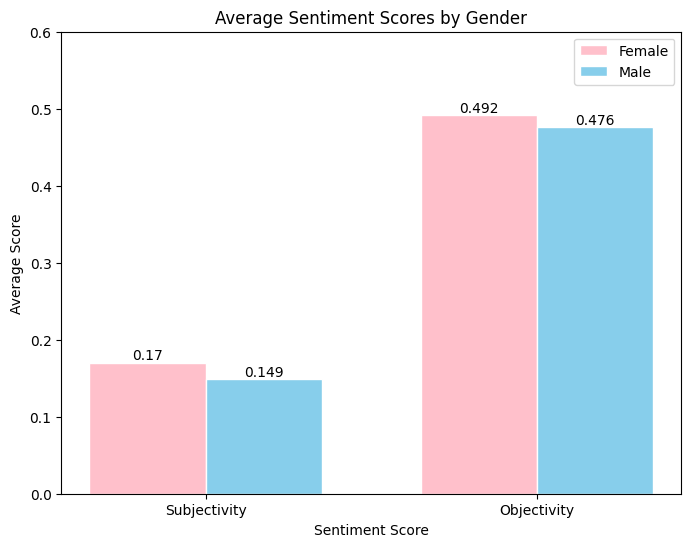

In [ ]:
#@title Sentiment analysis of Diary Entries by gender
# prompt: # prompt: 要一个柱状图 其中有二组柱子，第一组有两根（左边表示女生的情感值数据来自Female_df['sentiment_score_subjectivity'].mean()， 右边表示男的情感值数据 Male_df['sentiment_score_subjectivity'].mean() ）， 第二组有两根（左边表示女生的情感值数据来自Female_df['sentiment_score_objectivity'].mean()， 右边表示男的情感值数据 Male_df['sentiment_score_objectivity'].mean() ）,女生颜色pink,男生颜色skyblue
# y轴的数据范围从0到0.6

import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
female_subjectivity = Female_df['sentiment_score_subjectivity'].mean()
male_subjectivity = Male_df['sentiment_score_subjectivity'].mean()
female_objectivity = Female_df['sentiment_score_objectivity'].mean()
male_objectivity = Male_df['sentiment_score_objectivity'].mean()

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len([female_subjectivity, female_objectivity]))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(r1, [female_subjectivity, female_objectivity], color='pink', width=bar_width, edgecolor='white', label='Female')
plt.bar(r2, [male_subjectivity, male_objectivity], color='skyblue', width=bar_width, edgecolor='white', label='Male')

# Add labels, title, and ticks
plt.xlabel('Sentiment Score')
plt.ylabel('Average Score')
plt.title('Average Sentiment Scores by Gender')
plt.xticks([r + bar_width / 2 for r in range(len([female_subjectivity, female_objectivity]))], ['Subjectivity', 'Objectivity'])
plt.ylim(0, 0.6) # Set y-axis limit


# Add value annotations
for i, val in enumerate([female_subjectivity, female_objectivity]):
  plt.text(i, val, round(val, 3), ha='center', va='bottom')

for i, val in enumerate([male_subjectivity, male_objectivity]):
  plt.text(i + bar_width, val, round(val, 3), ha='center', va='bottom')


# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# Assuming Female_df and Male_df already exist
female_subjectivity = Female_df['sentiment_score_subjectivity']
male_subjectivity = Male_df['sentiment_score_subjectivity']
female_objectivity = Female_df['sentiment_score_objectivity']
male_objectivity = Male_df['sentiment_score_objectivity']

# Function to perform normality test
def check_normality(data, group_name):
    stat, p = stats.shapiro(data)
    if p > 0.05:
        print(f"{group_name} follows normal distribution (p={p:.4f})")
        return True
    else:
        print(f"{group_name} does NOT follow normal distribution (p={p:.4f})")
        return False

# Function to perform Levene’s test for equal variances
def check_variance_equality(group1, group2, label1, label2):
    stat, p = stats.levene(group1, group2)
    if p > 0.05:
        print(f"Equal variances assumed for {label1} and {label2} (p={p:.4f})")
        return True
    else:
        print(f"Unequal variances for {label1} and {label2} (p={p:.4f})")
        return False

# Function to perform t-tests
def perform_t_test(group1, group2, label1, label2):
    normal1 = check_normality(group1, label1)
    normal2 = check_normality(group2, label2)

    if normal1 and normal2:  # If both distributions are normal
        equal_var = check_variance_equality(group1, group2, label1, label2)
        if equal_var:
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=True)  # Student’s t-test
            print(f"Student's t-test between {label1} and {label2}: t={t_stat:.4f}, p={p_val:.4f}")
        else:
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
            print(f"Welch's t-test between {label1} and {label2}: t={t_stat:.4f}, p={p_val:.4f}")
    else:
        # If normality is violated, perform a non-parametric test (Mann-Whitney U test)
        u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        print(f"Mann-Whitney U test between {label1} and {label2}: U={u_stat:.4f}, p={p_val:.4f}")

# Run t-tests for Subjectivity and Objectivity
print("\n--- Subjectivity Score Comparison ---")
perform_t_test(female_subjectivity, male_subjectivity, "Female Subjectivity", "Male Subjectivity")

print("\n--- Objectivity Score Comparison ---")
perform_t_test(female_objectivity, male_objectivity, "Female Objectivity", "Male Objectivity")



--- Subjectivity Score Comparison ---
Female Subjectivity follows normal distribution (p=0.3720)
Male Subjectivity follows normal distribution (p=0.2244)
Equal variances assumed for Female Subjectivity and Male Subjectivity (p=0.9033)
Student's t-test between Female Subjectivity and Male Subjectivity: t=1.1048, p=0.2838

--- Objectivity Score Comparison ---
Female Objectivity follows normal distribution (p=0.7065)
Male Objectivity follows normal distribution (p=0.1845)
Equal variances assumed for Female Objectivity and Male Objectivity (p=0.3210)
Student's t-test between Female Objectivity and Male Objectivity: t=1.2033, p=0.2444


### Average Entry Lengthes by words

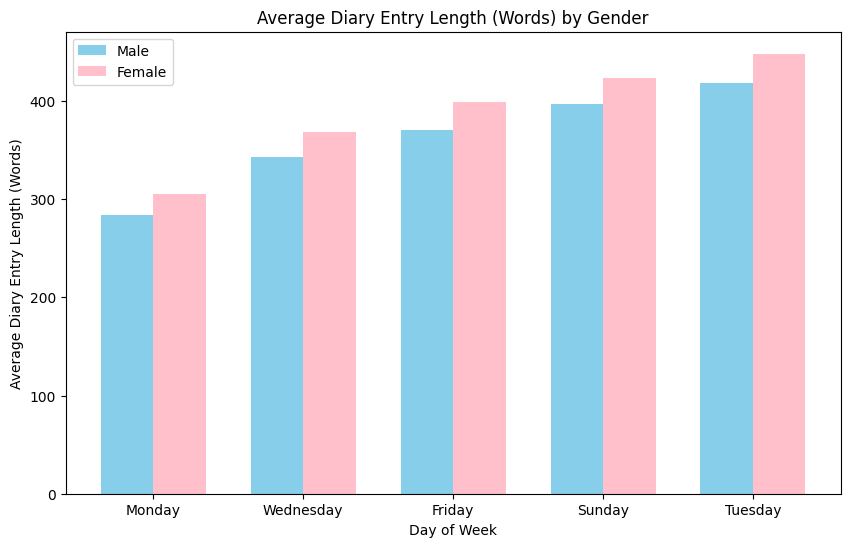

In [ ]:
# prompt: plot the average entry lengths by words not by characters and split between male and female # Create a bar chart
# plt.figure(figsize=(10, 6))
# days = ["Monday", "Wednesday", "Friday", "Sunday", "Tuesday"]
# plt.bar(days, average_word_counts)
# plt.xlabel("Day of Week")
# plt.ylabel("Average Diary Entry Length (Words)")
# plt.title("Average Diary Entry Length (Words) for Male")
# plt.show()
# female in pink

import matplotlib.pyplot as plt

# Calculate average word counts for male and female participants
average_word_counts_male = []
average_word_counts_female = []

for i in range(1, 6):
  male_entry_lengths = [len(entry.split()) for entry in Male_df[f'Diary_Entry_{i}'] if not pd.isna(entry)]
  female_entry_lengths = [len(entry.split()) for entry in Female_df[f'Diary_Entry_{i}'] if not pd.isna(entry)]

  if male_entry_lengths:
      average_word_counts_male.append(sum(male_entry_lengths) / len(male_entry_lengths))
  else:
      average_word_counts_male.append(0) # Handle cases where there's no data

  if female_entry_lengths:
      average_word_counts_female.append(sum(female_entry_lengths) / len(female_entry_lengths))
  else:
      average_word_counts_female.append(0)

days = ["Monday", "Wednesday", "Friday", "Sunday", "Tuesday"]

# Create the bar chart
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(days))
width = 0.35

plt.bar(x_pos - width/2, average_word_counts_male, width, label='Male', color='skyblue')
plt.bar(x_pos + width/2, average_word_counts_female, width, label='Female', color='pink')


plt.xlabel("Day of Week")
plt.ylabel("Average Diary Entry Length (Words)")
plt.title("Average Diary Entry Length (Words) by Gender")
plt.xticks(x_pos, days)
plt.legend()
plt.show()


In [ ]:
# join all Combined_Diary_Entries and separate female and male
combined_female_text = " ".join(Female_df['Combined_Diary_Entries'])
combined_male_text = " ".join(Male_df['Combined_Diary_Entries'])
# split combined_text with .
female_sentences = combined_female_text.split('.')
male_sentences = combined_male_text.split('.')
# remove empty strings
female_sentences = [sentence.strip() for sentence in female_sentences if sentence.strip()]
male_sentences = [sentence.strip() for sentence in male_sentences if sentence.strip()]

### Topic Modelling

In [ ]:
#@title Projection model_Diary_Entries
# Load Embedding model
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-MiniLM-L6-v2")

# Load Projection Model
import umap
projection_model = umap.UMAP(
                n_components= 2,
                random_state=42,
            )

from bunkatopics import Bunka

bunka_female = Bunka(embedding_model=embedding_model,
            projection_model=projection_model)

bunka_male = Bunka(embedding_model=embedding_model,
            projection_model=projection_model) # the language is automatically detected, make sure the embedding model is adapted

# Fit Bunka to your text data
# docs = Female_df[question_column].tolist()
# split docs in sentences
# sentences = []
# for doc in docs:
#     sentences.extend([phrase.strip() for phrase in doc.split('.')])
# sentences = list(set(sentences))
bunka_female.fit(female_sentences)
bunka_male.fit(male_sentences)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-03-06 20:23:49 - Bunka - INFO - Processing 22034 tokens
INFO:Bunka:Processing 22034 tokens
2025-03-06 20:23:49 - Bunka - INFO - Detected language: English
INFO:Bunka:Detected language: English
2025-03-06 20:23:49 - Bunka - INFO - Embedding documents... (can take varying amounts of time depending on their size)
INFO:Bunka:Embedding documents... (can take varying amounts of time depending on their size)


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

2025-03-06 20:23:59 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2025-03-06 20:24:08 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2025-03-06 20:24:08 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:10<00:00, 96.31it/s]
2025-03-06 20:24:19 - Bunka - INFO - Processing 20536 tokens
INFO:Bunka:Processing 20536 tokens
2025-03-06 20:24:19 - Bunka - INFO - Detected language: English
INFO:Bunka:Detected language: English
2025-03-06 20:24:19 - Bunka - INFO - Embedding documents... (can take varying amounts of time depending on their size)
INFO:Bunka:Embedding documents... (can take varying amounts of time depending on their size)


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

2025-03-06 20:24:29 - Bunka - INFO - Reducing the dimensions of embeddings...
INFO:Bunka:Reducing the dimensions of embeddings...
2025-03-06 20:24:30 - Bunka - INFO - Extracting meaningful terms from documents...
INFO:Bunka:Extracting meaningful terms from documents...
2025-03-06 20:24:30 - Bunka - INFO - Sampling 1000 documents for term extraction
INFO:Bunka:Sampling 1000 documents for term extraction
100%|██████████| 1000/1000 [00:06<00:00, 163.15it/s]


In [ ]:
female_topics = bunka_female.get_topics(n_clusters=10, name_length=5, min_count_terms = 1)
female_topics

2025-03-06 20:24:37 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics


,topic_id,topic_name,size,percent
0,bt-4,step | responsibilities | pressure | anxiety |...,160,14.77
1,bt-2,friends | plans | wash | stress | chat,144,13.30
2,bt-7,school | confidence | group | break | classroom,120,11.08
3,bt-0,week | challenges | weekend | night | peace,116,10.71
4,bt-9,dance | choir | music | ballet | practice,114,10.53
5,bt-5,art | feelings | novel | book | Writing,104,9.60
6,bt-8,walk | nature | air | animals | sun,96,8.86
7,bt-6,care | health | study | studies | grades,93,8.59
8,bt-1,exams | test | quiz | maths | math,84,7.76
9,bt-3,Today | whirlwind | bag | emotions | rollercoa...,52,4.80


In [ ]:
male_topics = bunka_male.get_topics(n_clusters=10, name_length=5, min_count_terms = 1)
male_topics

2025-03-06 20:24:37 - Bunka - INFO - Computing the topics
INFO:Bunka:Computing the topics


,topic_id,topic_name,size,percent
0,bt-2,exams | grades | stomach | knot | classmates,137,13.29
1,bt-6,confidence | victories | step | moments | dead...,133,12.90
2,bt-7,revision | focus | class | topics | mind,124,12.03
3,bt-9,hobbies | writing | ideas | siblings | art,124,12.03
4,bt-1,lunch | friends | dinner | park | walk,120,11.64
5,bt-0,anxiety | week | tomorrow | balance | today,114,11.06
6,bt-5,beach | waves | water | birds | weather,91,8.83
7,bt-8,geography | morning | anticipation | note | mo...,79,7.66
8,bt-3,music | guitar | podcast | videos | songs,57,5.53
9,bt-4,Today | rollercoaster | bag | whirlwind | emot...,52,5.04


In [ ]:
bunka_female.visualize_topics(width=800, height=800, colorscale='Blues', density = True,label_size_ratio = 60, convex_hull = True, show_text = True)

2025-03-06 20:24:37 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map


In [ ]:
bunka_male.visualize_topics(width=800, height=800, colorscale='Blues', density = True,label_size_ratio = 60, convex_hull = True, show_text = True)

2025-03-06 20:24:37 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map


In [ ]:
#@title Topics analysis
import pandas as pd
female_topics = pd.DataFrame([x.dict() for x in bunka_female.topics])
female_docs = pd.DataFrame([x.dict() for x in bunka_female.docs])
female_topics

,topic_id,name,lemma_name,term_id,x_centroid,y_centroid,size,top_doc_id,top_doc_content,top_term_id,convex_hull
0,bt-0,week | challenges | weekend | night | peace,None,"[week, challenges, weekend, night, peace, tomo...",0.669446,11.411348,116,None,[The morning started off on a high note as I f...,None,"{'x_coordinates': [-0.12230615317821504, -0.18..."
1,bt-1,exams | test | quiz | maths | math,None,"[exams, test, quiz, maths, math, maths test, e...",-3.342715,13.659360,84,None,"[However, the day took a turn when I got my ma...",None,"{'x_coordinates': [-3.936553478240965, -3.9689..."
2,bt-2,friends | plans | wash | stress | chat,None,"[friends, plans, wash, stress, chat, relief wa...",-1.759377,9.782842,144,None,"[During lunch, I tried to enjoy my time with f...",None,"{'x_coordinates': [-0.5779532194137572, -0.662..."
3,bt-3,Today | whirlwind | bag | emotions | rollercoa...,None,"[Today, whirlwind, bag, emotions, rollercoaste...",4.522557,12.290011,52,None,[**Entry Header:** Tuesday 19:00\n\n**Diary Co...,None,"{'x_coordinates': [4.328113079071045, 4.286556..."
4,bt-4,step | responsibilities | pressure | anxiety |...,None,"[step, responsibilities, pressure, anxiety, th...",-0.951542,11.868614,160,None,"[The pressure was immediate, and I felt that f...",None,"{'x_coordinates': [-1.9372017383575435, -1.897..."
5,bt-5,art | feelings | novel | book | Writing,None,"[art, feelings, novel, book, Writing, notebook...",-4.082383,10.387789,104,None,"[To unwind, I curled up with my fantasy novel ...",None,"{'x_coordinates': [-4.454121112823486, -4.6075..."
6,bt-6,care | health | study | studies | grades,None,"[care, health, study, self care, studies, grad...",-1.958245,13.400105,93,None,[I’ve been trying to create a study schedule t...,None,"{'x_coordinates': [-1.331947684288025, -1.2213..."
7,bt-7,school | confidence | group | break | classroom,None,"[school, confidence, group, break, classroom, ...",-2.980013,12.007768,120,None,"[School was relatively calm, with a few quizze...",None,"{'x_coordinates': [-3.962964296340943, -3.9057..."
8,bt-8,walk | nature | air | animals | sun,None,"[walk, nature, air, animals, sun, park, garden...",0.313082,9.035025,96,None,[I took a deep breath and focused on the sound...,None,"{'x_coordinates': [-0.7836953401565552, -0.736..."
9,bt-9,dance | choir | music | ballet | practice,None,"[dance, choir, music, ballet, practice, drama,...",-1.765252,7.629857,114,None,"[Later, at ballet practice, I noticed my conce...",None,"{'x_coordinates': [-2.8955299854278564, -2.917..."


In [ ]:
male_topics = pd.DataFrame([x.dict() for x in bunka_male.topics])
male_docs = pd.DataFrame([x.dict() for x in bunka_male.docs])
male_topics

,topic_id,name,lemma_name,term_id,x_centroid,y_centroid,size,top_doc_id,top_doc_content,top_term_id,convex_hull
0,bt-0,anxiety | week | tomorrow | balance | today,None,"[anxiety, week, tomorrow, balance, today, high...",4.826021,12.480390,114,None,[I ended the day feeling a mix of productivity...,None,"{'x_coordinates': [4.455249786376954, 4.569352..."
1,bt-1,lunch | friends | dinner | park | walk,None,"[lunch, friends, dinner, park, walk, game, fie...",2.406763,8.994991,120,None,"[During lunch, I joined my friends for some ru...",None,"{'x_coordinates': [1.6843905448913565, 1.59989..."
2,bt-2,exams | grades | stomach | knot | classmates,None,"[exams, grades, stomach, knot, classmates, pre...",2.517758,13.871103,137,None,"[In English class, we had a surprise quiz, and...",None,"{'x_coordinates': [1.5841298103332517, 1.48551..."
3,bt-3,music | guitar | podcast | videos | songs,None,"[music, guitar, podcast, videos, songs, drumst...",0.783515,9.931683,57,None,[I picked up my guitar and played a few chords...,None,"{'x_coordinates': [1.11340069770813, 1.2173559..."
4,bt-4,Today | rollercoaster | bag | whirlwind | emot...,None,"[Today, rollercoaster, bag, whirlwind, emotion...",8.702035,13.329053,52,None,[**Entry Header:** Friday 20:00\n\n**Diary Con...,None,"{'x_coordinates': [8.364121437072754, 8.289439..."
5,bt-5,beach | waves | water | birds | weather,None,"[beach, waves, water, birds, weather, clean, s...",4.300233,9.424709,91,None,"[The moment I paddled out into the waves, the ...",None,"{'x_coordinates': [4.405107975006105, 4.299690..."
6,bt-6,confidence | victories | step | moments | dead...,None,"[confidence, victories, step, moments, deadlin...",3.763902,11.074702,133,None,[It’s like a reset button for me; the peaceful...,None,"{'x_coordinates': [3.0899369716644283, 2.99875..."
7,bt-7,revision | focus | class | topics | mind,None,"[revision, focus, class, topics, mind, math, P...",0.901501,13.250690,124,None,[The topics we were covering felt overwhelming...,None,"{'x_coordinates': [0.268924742937088, 0.270169..."
8,bt-8,geography | morning | anticipation | note | mo...,None,"[geography, morning, math exam, school week, a...",3.772411,14.385378,79,None,[The morning started off on a good note; I fel...,None,"{'x_coordinates': [3.6845197677612287, 3.57966..."
9,bt-9,hobbies | writing | ideas | siblings | art,None,"[hobbies, writing, ideas, siblings, art, story...",2.022800,11.825015,124,None,"[When I got home, I tried to distract myself b...",None,"{'x_coordinates': [1.3692891597747803, 1.48842..."


In [ ]:
#@title Clean topics
# import os
# from google.colab import userdata
from langchain.llms import OpenAI
llm=ChatOpenAI(api_key=OPENAI_API_KEY, model="gpt-4o-mini", temperature=1)

female_topics_clean = bunka_female.get_clean_topic_name(llm=llm)
male_topics_clean = bunka_male.get_clean_topic_name(llm=llm)

2025-03-06 20:24:38 - Bunka - INFO - Using LLM to make topic names cleaner
INFO:Bunka:Using LLM to make topic names cleaner
Creating new labels for clusters: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]
2025-03-06 20:24:45 - Bunka - INFO - Using LLM to make topic names cleaner
INFO:Bunka:Using LLM to make topic names cleaner
Creating new labels for clusters: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


In [ ]:
female_topics_clean

,topic_id,topic_name,size,percent
0,bt-4,Managing Life Challenges,160,14.77
1,bt-2,Friendship and Stress,144,13.30
2,bt-7,School Confidence Dynamics,120,11.08
3,bt-0,Life's Weekly Balance,116,10.71
4,bt-9,Performing Arts,114,10.53
5,bt-5,Creative Expression Writing,104,9.60
6,bt-8,Nature Walks Adventure,96,8.86
7,bt-6,Health and Education,93,8.59
8,bt-1,Mathematics Assessment Tools,84,7.76
9,bt-3,Emotional Chaos,52,4.80


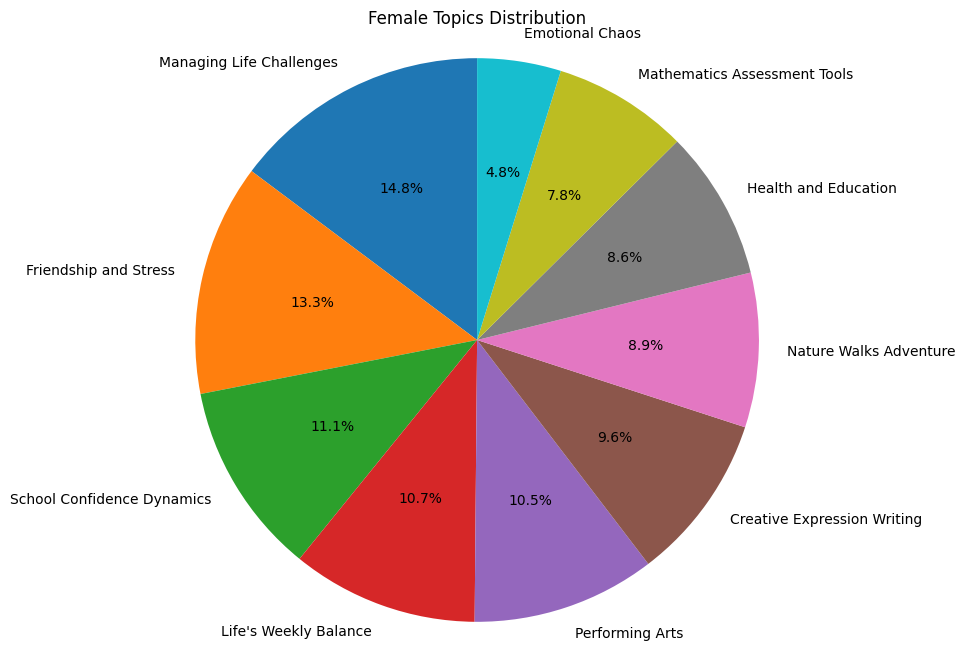

In [ ]:
#@title Female Topic Distributions Chart
# prompt: 针对female_topics_clean，他是个df类型，以topic_name和 percent画饼图

import matplotlib.pyplot as plt

# Assuming female_topics_clean is a DataFrame with 'topic_name' and 'percent' columns
plt.figure(figsize=(8, 8))
plt.pie(female_topics_clean['percent'], labels=female_topics_clean['topic_name'], autopct='%1.1f%%', startangle=90)
plt.title('Female Topics Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
male_topics_clean

,topic_id,topic_name,size,percent
0,bt-2,Academic Stress Management,137,13.29
1,bt-6,Personal Growth Journey,133,12.90
2,bt-7,Study Strategies,124,12.03
3,bt-9,Creative Expressions,124,12.03
4,bt-1,Social Outings Activities,120,11.64
5,bt-0,Emotional Well-being,114,11.06
6,bt-5,Coastal Scenes,91,8.83
7,bt-8,Morning Motivation Geography,79,7.66
8,bt-3,Creative Sound Media,57,5.53
9,bt-4,Emotional Rollercoaster Experience,52,5.04


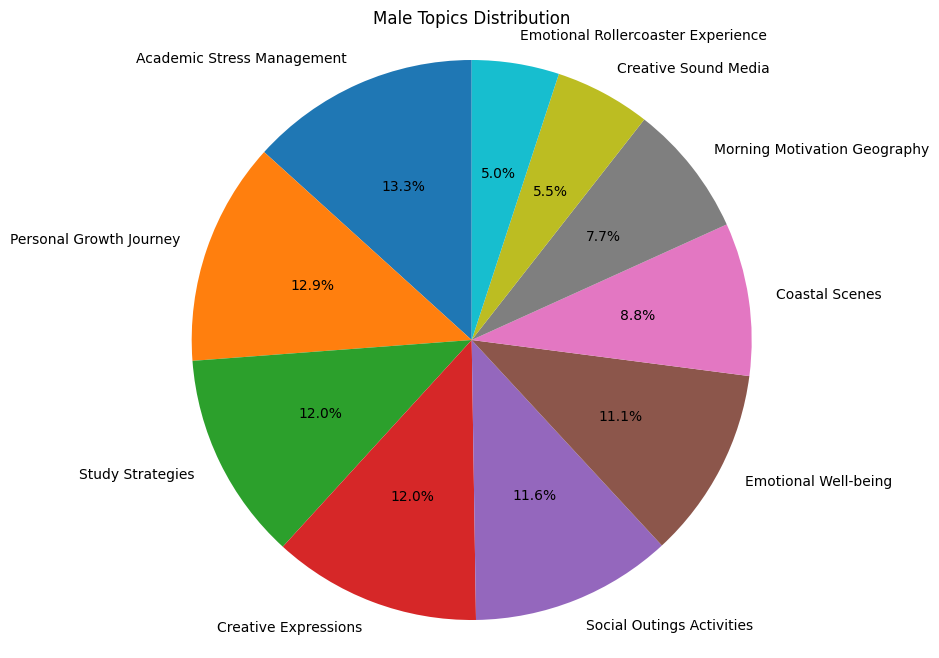

In [ ]:
#@title Male Topic Distributions Chart
import matplotlib.pyplot as plt

# Assuming male_topics_clean is a DataFrame with 'topic_name' and 'percent' columns
plt.figure(figsize=(9,8))
plt.pie(male_topics_clean['percent'], labels=male_topics_clean['topic_name'], autopct='%1.1f%%', startangle=90)
plt.title('Male Topics Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
#@title Common topics between female and male
# prompt: 已知 female_topic_clean 是一个df类型，male_topic_clean 是一个df类型， 他们都有一个叫“topic_name"的列, 这一列由字符串组成， 请先将他们按空格隔开，找到相同的字符串并打印出来

# Assuming female_topics_clean and male_topics_clean are DataFrames with a 'topic_name' column.

female_topic_names = female_topics_clean['topic_name'].str.split().explode()
male_topic_names = male_topics_clean['topic_name'].str.split().explode()

common_topics = set(female_topic_names) & set(male_topic_names)

common_topics


{'Creative', 'Emotional', 'Stress'}

In [ ]:
#@title Female Specific Topics and Male Specific Topics
# prompt: 已知 female_topic_clean 是一个df类型，male_topic_clean 是一个df类型， 他们都有一个叫“topic_name"的列, 这一列由字符串组成， 请先将他们按空格隔开，找到不同的字符串并打印出来

female_topic_names = female_topics_clean['topic_name'].dropna().unique()
male_topic_names = male_topics_clean['topic_name'].dropna().unique()

# Find topics present in female_topics_clean but not in male_topics_clean
female_only_topics = set(female_topic_names) - set(male_topic_names)
print("Topics only in female data:")
print(female_only_topics)

# Find topics present in male_topics_clean but not in female_topics_clean
male_only_topics = set(male_topic_names) - set(female_topic_names)
print("\nTopics only in male data:")
male_only_topics


Topics only in female data:
{'Emotional Chaos', 'Performing Arts', 'School Confidence Dynamics', 'Mathematics Assessment Tools', 'Friendship and Stress', 'Creative Expression Writing', 'Nature Walks Adventure', 'Managing Life Challenges', 'Health and Education', "Life's Weekly Balance"}

Topics only in male data:


{'Academic Stress Management',
 'Coastal Scenes',
 'Creative Expressions',
 'Creative Sound Media',
 'Emotional Rollercoaster Experience',
 'Emotional Well-being',
 'Morning Motivation Geography',
 'Personal Growth Journey',
 'Social Outings Activities',
 'Study Strategies'}

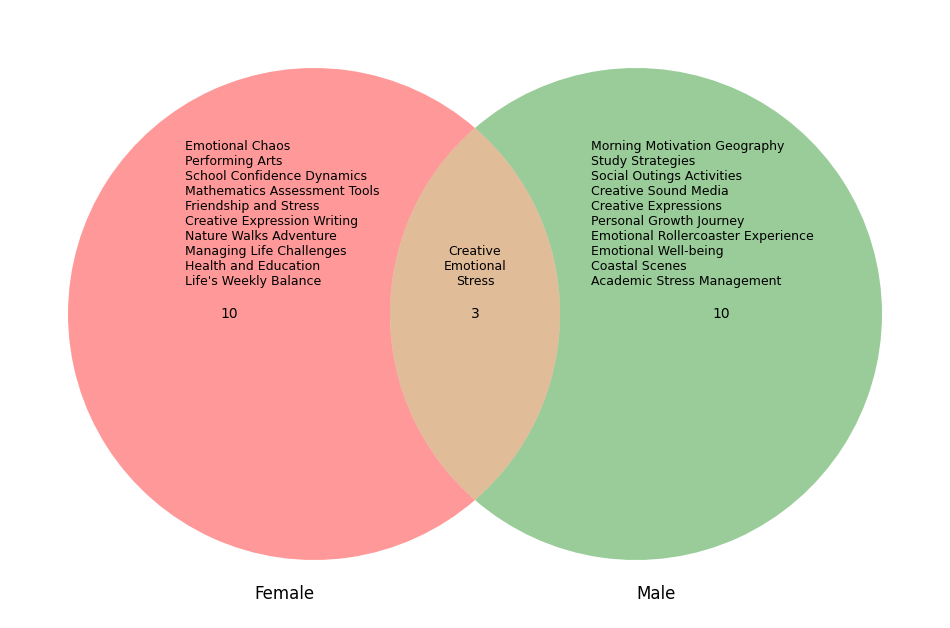

In [ ]:
#@title Venn Diagram of convergent and divergent topics
# prompt: draw a venn diagram for Topics only in female data; Topics only in male data; common_topics, show the topics

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Assuming female_only_topics, male_only_topics, and common_topics are defined as in your code

# Convert sets to lists for venn2
female_only_topics_list = list(female_only_topics)
male_only_topics_list = list(male_only_topics)
common_topics_list = list(common_topics)
plt.figure(figsize=(12, 9))  # Increased figure size

venn2(subsets = (len(female_only_topics), len(male_only_topics), len(common_topics)), set_labels = ('Female', 'Male'))
# plt.title("Venn Diagram of Topics")

# Add topic labels
# Customize the position of the labels to avoid overlapping
plt.text(-0.5, 0.05, "\n".join(female_only_topics_list), fontsize=9)
plt.text(0.2, 0.05, "\n".join(male_only_topics_list), fontsize=9)
plt.text(0.0, 0.05, "\n".join(common_topics_list), fontsize=9, ha='center')

plt.show()


In [ ]:
bunka_female.visualize_topics(width=800, height=1000, colorscale='Portland', density = True,label_size_ratio = 60, convex_hull = True)

2025-03-06 20:24:50 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map


In [ ]:
bunka_male.visualize_topics(width=800, height=800, colorscale='Portland', density = True,label_size_ratio = 60, convex_hull = True)

2025-03-06 20:24:50 - Bunka - INFO - Creating the Bunka Map
INFO:Bunka:Creating the Bunka Map


### Anxiety Invetsigation Prior and Post Intervention

In [ ]:
#@title Paired T-test prior vs post GAD score
# prompt: paried t test comparing Total_Prior_GAD_Score and Total_Post_GAD_Score, and show mean

import scipy.stats as stats

# Perform t-test
t_stat, p_value = stats.ttest_rel(df['Total_Prior_GAD_Score'], df['Total_Post_GAD_Score'])

# Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Calculate and print means
prior_mean = df['Total_Prior_GAD_Score'].mean()
post_mean = df['Total_Post_GAD_Score'].mean()

print(f"Mean of Total_Prior_GAD_Score: {prior_mean}")
print(f"Mean of Total_Post_GAD_Score: {post_mean}")


T-statistic: -6.307135358228429
P-value: 4.706511699198111e-06
Mean of Total_Prior_GAD_Score: 7.0
Mean of Total_Post_GAD_Score: 8.55


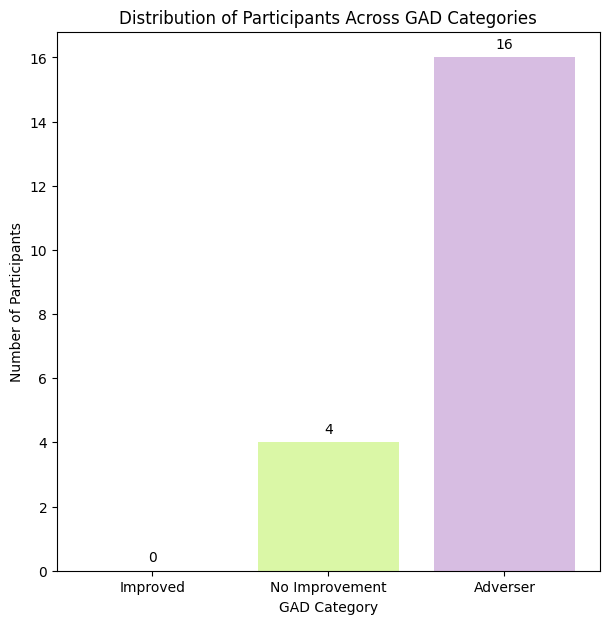

In [ ]:
#@title Numbers of participants within three categopries
# prompt: add a bar chart with three caetgories add number on the topic of it

import matplotlib.pyplot as plt

# Data for the bar chart
categories = ['Improved', 'No Improvement', 'Adverser']
values = [improved_count, no_improvement_count, adverser_count]

# Create the bar chart
plt.figure(figsize=(7, 7))
plt.bar(categories, values, color=['green', '#DAF7A6', '#d7bde2'])  # Customize colors as needed

# Add labels and title
plt.xlabel("GAD Category")
plt.ylabel("Number of Participants")
plt.title("Distribution of Participants Across GAD Categories")

# Add value labels above each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom') # Adjust vertical position as needed


# Show the plot
plt.show()


In [ ]:
#@title Independent T-test prior vs post GAD score for Adverser
# prompt: compare  the mean of Total_Prior_GAD_Score and Total_Post_GAD_Score between, Improved: 0
# No Improvement: 3
# Adverser: 17

# Assuming 'df' is your DataFrame from the previous code
import pandas as pd
import scipy.stats as stats

# Group data by GAD category and calculate mean GAD scores
grouped_data = df.groupby('GAD_Category').agg(
    {'Total_Prior_GAD_Score': 'mean', 'Total_Post_GAD_Score': 'mean'}
)
print(grouped_data)

# Perform t-tests for each category if you have paired data
# For example, for the 'improved' category
improved_group = df[df['GAD_Category'] == 'improved']
t_stat, p_value = stats.ttest_rel(
    improved_group['Total_Prior_GAD_Score'], improved_group['Total_Post_GAD_Score']
)
print(f"T-test for Improved group: t-statistic = {t_stat}, p-value = {p_value}")


# Similarly, you can perform t-tests for 'no improvement' and 'adverser' categories
no_improvement_group = df[df['GAD_Category'] == 'no improvement']
t_stat, p_value = stats.ttest_rel(
    no_improvement_group['Total_Prior_GAD_Score'],
    no_improvement_group['Total_Post_GAD_Score'],
)
print(f"T-test for No Improvement group: t-statistic = {t_stat}, p-value = {p_value}")

adverser_group = df[df['GAD_Category'] == 'adverser']
t_stat, p_value = stats.ttest_rel(
    adverser_group['Total_Prior_GAD_Score'], adverser_group['Total_Post_GAD_Score']
)
print(f"T-test for Adverser group: t-statistic = {t_stat}, p-value = {p_value}")


                Total_Prior_GAD_Score  Total_Post_GAD_Score
GAD_Category                                               
adverser                          7.0                8.9375
no improvement                    7.0                7.0000
T-test for Improved group: t-statistic = nan, p-value = nan
T-test for No Improvement group: t-statistic = nan, p-value = nan
T-test for Adverser group: t-statistic = -9.075870678421358, p-value = 1.761526993520628e-07


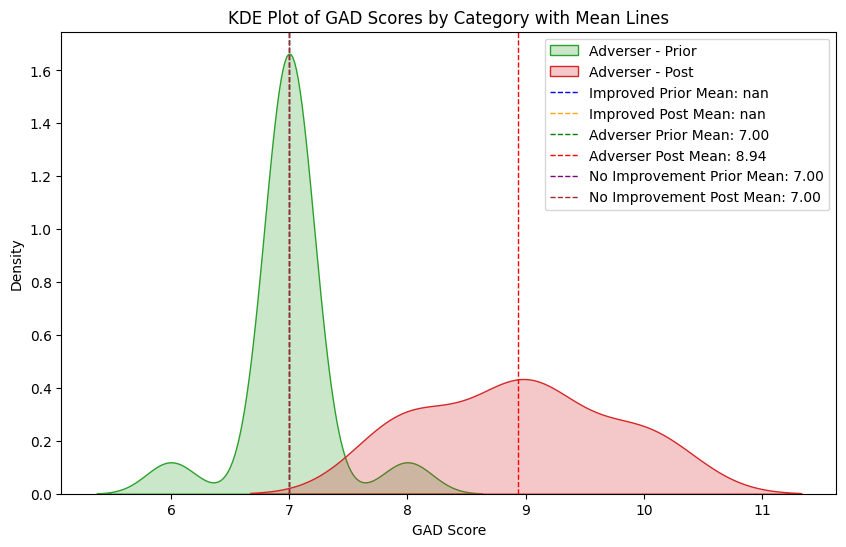

In [ ]:
#@title KDE graph comparing prior vs post GAD score among adverser, no improvement and improved group

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['GAD_Category'] == 'improved']['Total_Prior_GAD_Score'], label='Improved - Prior', shade=True)
sns.kdeplot(df[df['GAD_Category'] == 'improved']['Total_Post_GAD_Score'], label='Improved - Post', shade=True)
sns.kdeplot(df[df['GAD_Category'] == 'adverser']['Total_Prior_GAD_Score'], label='Adverser - Prior', shade=True)
sns.kdeplot(df[df['GAD_Category'] == 'adverser']['Total_Post_GAD_Score'], label='Adverser - Post', shade=True)
sns.kdeplot(df[df['GAD_Category'] == 'no improvement']['Total_Prior_GAD_Score'], label='No Improvement - Prior', shade=True)
sns.kdeplot(df[df['GAD_Category'] == 'no improvement']['Total_Post_GAD_Score'], label='No Improvement - Post', shade=True)

# Calculate the mean for each group
improved_prior_mean = df[df['GAD_Category'] == 'improved']['Total_Prior_GAD_Score'].mean()
improved_post_mean = df[df['GAD_Category'] == 'improved']['Total_Post_GAD_Score'].mean()
adverser_prior_mean = df[df['GAD_Category'] == 'adverser']['Total_Prior_GAD_Score'].mean()
adverser_post_mean = df[df['GAD_Category'] == 'adverser']['Total_Post_GAD_Score'].mean()
no_improvement_prior_mean = df[df['GAD_Category'] == 'no improvement']['Total_Prior_GAD_Score'].mean()
no_improvement_post_mean = df[df['GAD_Category'] == 'no improvement']['Total_Post_GAD_Score'].mean()


# Add mean lines to the plot
plt.axvline(improved_prior_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Improved Prior Mean: {improved_prior_mean:.2f}')
plt.axvline(improved_post_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Improved Post Mean: {improved_post_mean:.2f}')
plt.axvline(adverser_prior_mean, color='green', linestyle='dashed', linewidth=1, label=f'Adverser Prior Mean: {adverser_prior_mean:.2f}')
plt.axvline(adverser_post_mean, color='red', linestyle='dashed', linewidth=1, label=f'Adverser Post Mean: {adverser_post_mean:.2f}')
plt.axvline(no_improvement_prior_mean, color='purple', linestyle='dashed', linewidth=1, label=f'No Improvement Prior Mean: {no_improvement_prior_mean:.2f}')
plt.axvline(no_improvement_post_mean, color='brown', linestyle='dashed', linewidth=1, label=f'No Improvement Post Mean: {no_improvement_post_mean:.2f}')


plt.xlabel('GAD Score')
plt.ylabel('Density')
plt.title('KDE Plot of GAD Scores by Category with Mean Lines')
plt.legend()
plt.show()


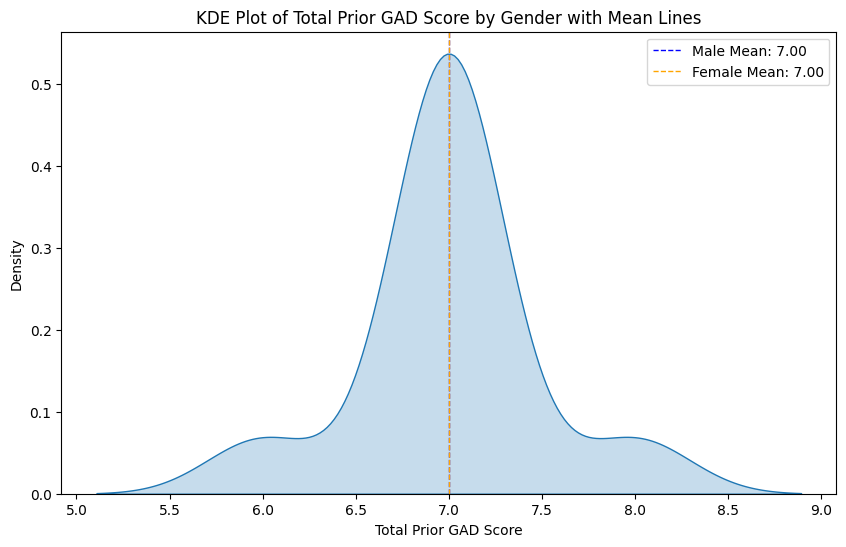

In [ ]:
#@title KDE plot of Prior GAD score by gender
# prompt: kde graph comparing Total_Post GAD_Score' by gender with mean line

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and contains 'Total_Post_GAD_Score' and 'gender' columns
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Total_Prior_GAD_Score', hue='gender', shade=True)

# Calculate the mean GAD score for each gender
male_mean = df[df['gender'] == 'male']['Total_Prior_GAD_Score'].mean()
female_mean = df[df['gender'] == 'female']['Total_Prior_GAD_Score'].mean()

# Add vertical lines for the means
plt.axvline(male_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Male Mean: {male_mean:.2f}')
plt.axvline(female_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Female Mean: {female_mean:.2f}')

plt.xlabel('Total Prior GAD Score')
plt.ylabel('Density')
plt.title('KDE Plot of Total Prior GAD Score by Gender with Mean Lines')
plt.legend()
plt.show()


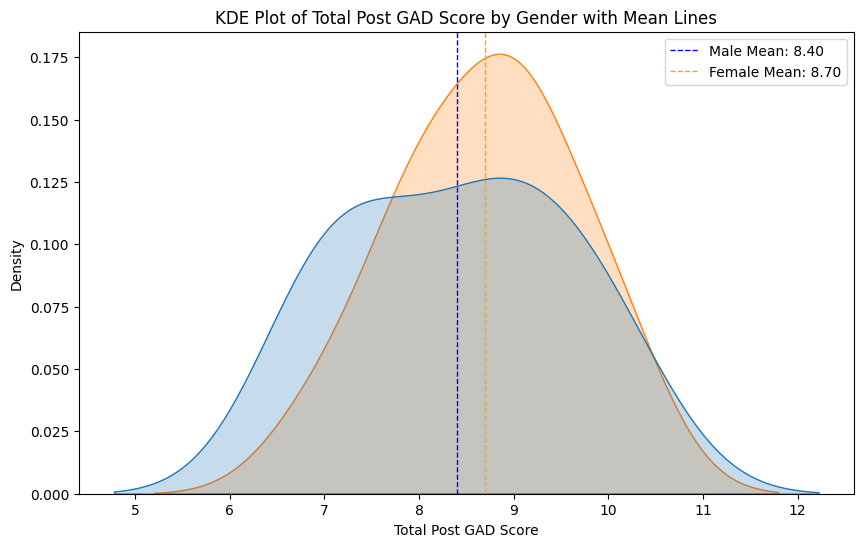

In [ ]:
#@title KDE plot of Post GAD score by gender
# prompt: kde graph comparing Total_Post GAD_Score' by gender with mean line

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and contains 'Total_Post_GAD_Score' and 'gender' columns
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Total_Post_GAD_Score', hue='gender', shade=True)

# Calculate the mean GAD score for each gender
male_mean = df[df['gender'] == 'male']['Total_Post_GAD_Score'].mean()
female_mean = df[df['gender'] == 'female']['Total_Post_GAD_Score'].mean()

# Add vertical lines for the means
plt.axvline(male_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Male Mean: {male_mean:.2f}')
plt.axvline(female_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Female Mean: {female_mean:.2f}')

plt.xlabel('Total Post GAD Score')
plt.ylabel('Density')
plt.title('KDE Plot of Total Post GAD Score by Gender with Mean Lines')
plt.legend()
plt.show()


In [ ]:
# prompt: read /content/Complete1.csv

import pandas as pd

df = pd.read_csv('/content/Complete1.csv')
df


,Unnamed: 0.1,Unnamed: 0,pid,participant_type,age,gender,lives_in,educational_attainment,family_size,subjects_studying,...,Post_Intervention_GAD_5_reason,Post_Intervention_GAD_6_n,Post_Intervention_GAD_6_reason,Post_Intervention_GAD_7_n,Post_Intervention_GAD_7_reason,Total_Post_GAD_Score,Post_Anxiety_Category,Combined_Diary_Entries,Combined_Post_Intervention_GAD_reason,GAD_Category
0,0,0,1,college student,12,male,"Manchester, suburban area",Secondary Education (Year 8),4,"['Mathematics', 'English', 'Science', 'Geograp...",...,"I felt restless sometimes, especially when I h...",1,"I have felt a bit annoyed at times, especially...",1,I felt afraid a few times over the last two we...,8,Mild Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,"During the last two weeks, I felt nervous, esp...",adverser
1,1,1,2,college student,13,female,"London, urban area",Secondary Education (Year 9),3,"['English', 'Art', 'Science', 'French']",...,"I have felt restless at times, especially when...",1,"Several days - During the last two weeks, I fe...",1,"Several days - During the last two weeks, I fe...",9,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,"During the last two weeks, I felt nervous a fe...",adverser
2,2,2,3,college student,14,male,"Birmingham, urban area",Secondary Education (Year 10),5,"['Mathematics', 'History', 'English', 'Compute...",...,"Several days. During the last two weeks, I fel...",1,"I have felt more irritable lately, especially ...",1,"Several days - During the last two weeks, I so...",8,Mild Anxiety,- **Entry Header:** Monday 16:30 \n- **Diary ...,More than half the days. During the last two w...,adverser
3,3,3,4,college student,15,female,"Leeds, suburban area",Secondary Education (Year 11),4,"['English Literature', 'Biology', 'Music', 'Re...",...,"During the last two weeks, I felt restless on ...",1,"I have felt irritable a few times, especially ...",1,"Several days - During the last two weeks, I've...",10,Moderate Anxiety,- **Entry Header:** Monday 16:30\n- **Diary Co...,More than half the days. During the last two w...,adverser
4,4,4,5,college student,16,male,"Bristol, urban area",Secondary Education (Year 12; starting college...,3,"['Mathematics (A-Level)', 'Physics (A-Level)',...",...,More than half the days. I’ve been restless of...,1,I felt irritable several days during the last ...,1,Several days. I have felt nervous a few days d...,10,Moderate Anxiety,- **Entry Header:** Monday 15:30 \n- **Diary ...,More than half the days. I have been feeling a...,adverser
5,5,5,6,college student,12,female,"Glasgow, urban area",Secondary Education (Year 8 equivalent in Scot...,5,"['English', 'Scottish History', 'Mathematics',...",...,"Several days. During the last two weeks, I fel...",1,"During the last two weeks, I felt irritated on...",1,Several days; I've felt a bit afraid about exa...,8,Mild Anxiety,- **Entry Header:** Monday 17:30 \n- **Diary ...,"I've felt nervous and anxious on several days,...",adverser
6,6,6,7,college student,13,male,"Cardiff, suburban area",Secondary Education (Year 9),4,"['Welsh Language', 'English', 'Mathematics', '...",...,"Over the last two weeks, I have felt restless ...",1,I have felt a bit overwhelmed with schoolwork ...,1,"I've felt a bit afraid occasionally, especiall...",10,Moderate Anxiety,- **Entry Header:** Monday 17:30\n- **Diary Co...,More than half the days. I found myself feelin...,adverser
7,7,7,8,college student,14,female,"Liverpool, suburban area",Secondary Education (Year 10),6,"['English Literature', 'Music', 'Biology', 'Ge...",...,"Over the last two weeks, I found myself feelin...",1,"I have felt irritated at times, especially whe...",1,Several days. I felt afraid sometimes when I t...,9,Mild Anxiety,**Entry Header:** Monday 16:30\n\n**Diary Cont...,"Several days. I felt nervous and anxious, espe...",adverser
8,8,8,9,college student,15,male,"Sheffield, urban area",Secondary Education (Year 11),4,"['Mathematics', 'Physics', 'Art', 'Computer Sc...",...,"Severa

In [ ]:
Female_df = df[df['gender'] == 'female']
Male_df = df[df['gender'] == 'male']

In [ ]:
#@title Paired Sample T test on Female Participants

from scipy import stats

# Assuming Female_df has 'Total_Prior_GAD_Score' and 'Total_Post_GAD_Score' columns
t_stat, p_value = stats.ttest_rel(Female_df['Total_Prior_GAD_Score'], Female_df['Total_Post_GAD_Score'])

print(f"Paired sample t-test for Female participants:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

alpha = 0.05  # Significance level
if p_value < alpha:
    print("The difference between prior and post GAD scores is statistically significant for female participants.")
else:
    print("The difference between prior and post GAD scores is not statistically significant for female participants.")


Paired sample t-test for Female participants:
T-statistic: -5.666666666666667
P-value: 0.00030702199630096354
The difference between prior and post GAD scores is statistically significant for female participants.
